#Exercise 03: Usage of Deep Learning and Transfer Learning Model for Named Entity Recognition (NER) on the Ontonotes5 dataset

Name: Daniel Podolecki
\
Date: 13.01.2023

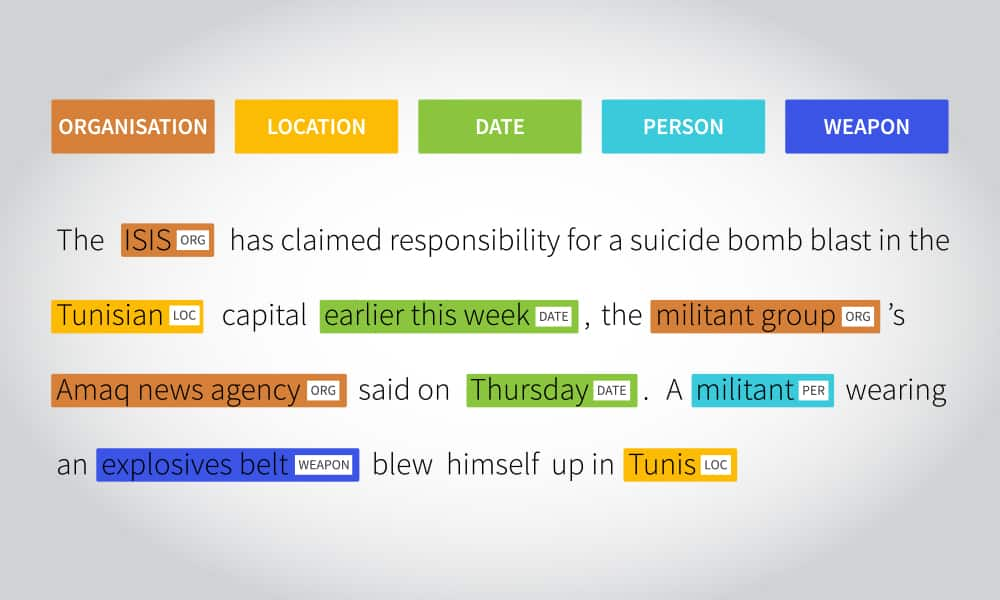

Picture: Symbolic picture for Named Entity Recognition  (NER) - -> [Source](https://www.shaip.com/wp-content/uploads/2022/02/Blog_Named-Entity-Recognition-%E2%80%93-The-Concept-Types-Applications.jpg)

## Setup


Change the runtime to GPU! Otherwise it will take much more time to compute the model!!!! I tried this out and it took more than 1 hour with CPU (I stopped at batch 100 so it would be even longer)!!! 

In [ ]:
!nvidia-smi

Sun Jan  8 16:25:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    51W / 400W |  40458MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import packages needed (or might be needed)

from google.colab import drive
from pathlib import Path
import os

import json
from itertools import chain
import datasets

import math
import random
import copy
import tqdm
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import transformers
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
from pprint import pprint

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

from sklearn.metrics import f1_score
from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read and Preprocess the Dataset

Ontonotes5 dataset comes in a part of the [TNER](https://github.com/asahi417/tner) project.
It consists of a large collection of news articles, transcribed radio and television broadcasts, and weblogs annotated with entity, event, and relation information. The dataset is annotated in the framework of the PropBank, NomBank, and FrameNet projects, with additional annotation for coreference and entity linking. 

This dataset contains a sequence of tokens and tags for each split.

The dataset has the following Entity Types: 
CARDINAL, DATE, PERSON, NORP, GPE, LAW, PERCENT, ORDINAL, MONEY, WORK_OF_ART, FAC, TIME, QUANTITY, PRODUCT, LANGUAGE, ORG, LOC, EVENT

In [ ]:
# Overview of the Dataset:

""" NER dataset compiled by T-NER library https://github.com/asahi417/tner/tree/master/tner """

logger = datasets.logging.get_logger(__name__)
_DESCRIPTION = """[ontonotes5 NER dataset](https://aclanthology.org/N06-2015/)"""
_NAME = "ontonotes5"
_VERSION = "1.0.0"
_CITATION = """
@inproceedings{hovy-etal-2006-ontonotes,
    title = "{O}nto{N}otes: The 90{\%} Solution",
    author = "Hovy, Eduard  and
      Marcus, Mitchell  and
      Palmer, Martha  and
      Ramshaw, Lance  and
      Weischedel, Ralph",
    booktitle = "Proceedings of the Human Language Technology Conference of the {NAACL}, Companion Volume: Short Papers",
    month = jun,
    year = "2006",
    address = "New York City, USA",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/N06-2015",
    pages = "57--60",
}
"""

_HOME_PAGE = "https://github.com/asahi417/tner"
_URL = f'https://huggingface.co/datasets/tner/{_NAME}/raw/main/dataset'
_URLS = {
    str(datasets.Split.TEST): [f'{_URL}/test.json'],
    str(datasets.Split.TRAIN): [f'{_URL}/train{i:02d}.json' for i in range(4)],
    str(datasets.Split.VALIDATION): [f'{_URL}/valid.json'],
}


In [ ]:
_URLS

{'test': ['https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/test.json'],
 'train': ['https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/train00.json',
  'https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/train01.json',
  'https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/train02.json',
  'https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/train03.json'],
 'validation': ['https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/valid.json']}

In [ ]:
!wget https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/train00.json #there a multiple train sets. another option is train01, train02 or train03
!wget https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/test.json
!wget https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/valid.json

--2023-01-08 16:25:38--  https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/train00.json
Resolving huggingface.co (huggingface.co)... 34.236.220.178, 34.198.93.197, 3.231.67.228, ...
Connecting to huggingface.co (huggingface.co)|34.236.220.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4744562 (4.5M) [text/plain]
Saving to: ‘train00.json.3’

train00.json.3      100%[===================>]   4.52M  6.59MB/s    in 0.7s    

2023-01-08 16:25:39 (6.59 MB/s) - ‘train00.json.3’ saved [4744562/4744562]

--2023-01-08 16:25:39--  https://huggingface.co/datasets/tner/ontonotes5/raw/main/dataset/test.json
Resolving huggingface.co (huggingface.co)... 34.236.220.178, 34.198.93.197, 3.231.67.228, ...
Connecting to huggingface.co (huggingface.co)|34.236.220.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915230 (1.8M) [text/plain]
Saving to: ‘test.json.3’

test.json.3         100%[===================>]   1.83M  3.05MB/s    in 

To read and preprocess the dataset in order to use the model according to the lecture I have to create a Class which has a similar logic:

In [ ]:
class Ontonotes5Dataset(Dataset):

    MAPPING_Y_NER_LABELS ={
      0: "O",
      1: "B-CARDINAL",
      2: "B-DATE",
      3: "I-DATE",
      4: "B-PERSON",
      5: "I-PERSON",
      6: "B-NORP",
      7: "B-GPE",
      8: "I-GPE",
      9: "B-LAW",
      10: "I-LAW",
      11: "B-ORG",
      12: "I-ORG",
      13: "B-PERCENT",
      14: "I-PERCENT",
      15: "B-ORDINAL",
      16: "B-MONEY",
      17: "I-MONEY",
      18: "B-WORK_OF_ART",
      19: "I-WORK_OF_ART",
      20: "B-FAC",
      21: "B-TIME",
      22: "I-CARDINAL",
      23: "B-LOC",
      24: "B-QUANTITY",
      25: "I-QUANTITY",
      26: "I-NORP",
      27: "I-LOC",
      28: "B-PRODUCT",
      29: "I-TIME",
      30: "B-EVENT",
      31: "I-EVENT",
      32: "I-FAC",
      33: "B-LANGUAGE",
      34: "I-PRODUCT",
      35: "I-ORDINAL",
      36: "I-LANGUAGE"
    }

          

    def __init__(self, filepaths,max_seq_len):
        self.data = [] #as list
        self.max_seq_len = max_seq_len

        for filepath in filepaths:
          with open(filepath, encoding="utf-8") as f:
                _list = [i for i in f.read().split('\n') if len(i) > 0] #take one sentence, splitted by \n
                # The data is already tokenized. Each row contains maximum one sentence. 
                for i in _list:
                    #print(i)
                    data = json.loads(i)
                    idx = len(self.data)
                    tokens = data['tokens']
                    labels = data['tags']

                    self.data.append({
                        'tokens': tokens,
                        'ners': labels, #note that this is different to the code the lecturer gave us, because the ners are in the dataset, and not the y_ners
                        'idx': idx,
                        'y_ners': [Ontonotes5Dataset.MAPPING_Y_NER_LABELS[label] for label in labels], # Reverse Mapping 0-36 classes to Y_Ner
                         'word_idx': [] # Later for word embeddings
                    })

    def __len__(self):  #this is needed for the DataLoader later!
        return len(self.data)

    def __getitem__(self, idx):  #this is needed for the DataLoader later!
    
        return {
            'idx': idx,
            'word_idx': torch.tensor(self.data[idx]['word_idx']).long(), 
            'ners': torch.tensor(self.data[idx]['ners']).long()
        }

In [ ]:
# Check if it is downloaded
!ls

drive		       glove.6B.zip    test.json.2     valid.json
glove.6B.100d.txt      glove.6B.zip.1  test.json.3     valid.json.1
glove.6B.100d_w2v.txt  glove.6B.zip.2  train00.json    valid.json.2
glove.6B.200d.txt      sample_data     train00.json.1  valid.json.3
glove.6B.300d.txt      test.json       train00.json.2
glove.6B.50d.txt       test.json.1     train00.json.3


In [ ]:
# get the current directory - check where it is downloaded
current_dir = os.getcwd()
print(current_dir)

# construct the file paths to the dataset files
train_filepath = os.path.join(current_dir, "train00.json")
validation_filepath = os.path.join(current_dir, "valid.json")
test_filepath = os.path.join(current_dir
                             , "test.json")

# create the file paths list
filepaths = [train_filepath, validation_filepath, test_filepath]

# create the dataset
dataset = Ontonotes5Dataset(filepaths, max_seq_len=210)

/content


In [ ]:
#Example: One row/sample
dataset.data[6]

{'tokens': ['Last',
  'week',
  ',',
  'Sen.',
  'Malcolm',
  'Wallop',
  '-LRB-',
  'R.',
  ',',
  'Wyo',
  '.',
  '-RRB-',
  'held',
  'hearings',
  'on',
  'a',
  'bill',
  'to',
  'strengthen',
  'an',
  'existing',
  'law',
  'designed',
  'to',
  'reduce',
  'regulatory',
  'hassles',
  'for',
  'small',
  'businesses',
  '.'],
 'ners': [2,
  3,
  0,
  0,
  4,
  5,
  0,
  6,
  0,
  7,
  8,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'idx': 6,
 'y_ners': ['B-DATE',
  'I-DATE',
  'O',
  'O',
  'B-PERSON',
  'I-PERSON',
  'O',
  'B-NORP',
  'O',
  'B-GPE',
  'I-GPE',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 'word_idx': []}

In [ ]:
# Test-Val-Train Split
train_data = Ontonotes5Dataset([train_filepath], max_seq_len=210)
val_data = Ontonotes5Dataset([validation_filepath], max_seq_len=210)
test_data = Ontonotes5Dataset([test_filepath], max_seq_len=210)

In [ ]:
# Example: Train Data
train_data.data[1]

{'tokens': ['But',
  'a',
  'chance',
  'to',
  'fill',
  'out',
  'sales',
  '-',
  'tax',
  'records',
  'is',
  'rarely',
  'one',
  'of',
  'them',
  '.'],
 'ners': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'idx': 1,
 'y_ners': ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-CARDINAL',
  'O',
  'O',
  'O'],
 'word_idx': []}

In [ ]:
# Example: Train Data
print(len(train_data.data[1]["ners"]))
print(len(train_data.data[1]["word_idx"]))

16
0


In [ ]:
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
# Check the lenghts
len(train_data), len(val_data), len(test_data) 

(15000, 8528, 8262)

## Build the vocabulary and word embedding matrix


At the begin it is necessary to build a vocabulary of all tokens which are mentioned in the text/list of tokens. Since it is a set each token will be unique (appears only one time).

In [ ]:
# Initialization of the vocabulary set
vocabulary = set()

# loop through the train dataset and add the tokens to the vocabulary set
for sample in train_data.data:
    for token in sample['tokens']:
        vocabulary.add(token)

# print the vocabulary size
print(len(vocabulary))

25503


**Interpretation**: Not too many words so there is no need to filter/reduce the vocabulary (< 30k). 

Next each vocabulary receives an index (and vice versa). For that the Vocabulary based set is the basis. For that an index is created by calculating the length of the word2idx set. Since there are two items already in the set (_PAD_ and _UNK_) the length of the set is intially on 2. For the first vocab is mapped to the initial index. Beginning from the vocab the word2idx set will naturally grow +1 each iteration, because it is a for loop.

In [ ]:
# Assign an index to each vocabulary entry:
word2idx = {'_PAD_': 0, '_UNK_': 1}#

print("Initial Index = ", len(word2idx))
print(30*"*")

for word in vocabulary:
  word2idx[word] = len(word2idx) 
idx2word = {idx:word for word, idx in word2idx.items()}
word2idx

Initial Index =  2
******************************


{'_PAD_': 0,
 '_UNK_': 1,
 'certainly': 2,
 'Ukrainian': 3,
 'notwithstanding': 4,
 'swindled': 5,
 '225': 6,
 'resignations': 7,
 'your': 8,
 'pro-family': 9,
 'Parental': 10,
 'demolishing': 11,
 'clippings': 12,
 'Vaclav': 13,
 'Mountain': 14,
 'DeVillars': 15,
 'trafficking': 16,
 'masses': 17,
 'state': 18,
 'aftermath': 19,
 'Brussels': 20,
 'atomic': 21,
 'haven': 22,
 'Marcel': 23,
 "'50s": 24,
 'Lorin': 25,
 'dropouts': 26,
 'R.I': 27,
 'anti-apartheid': 28,
 'wrack': 29,
 'Autry': 30,
 'friends': 31,
 'Itochu': 32,
 '39,000': 33,
 'merge': 34,
 'Relief': 35,
 'tenth': 36,
 'brother': 37,
 'condensers': 38,
 'code': 39,
 'ABCs': 40,
 '1,000': 41,
 'dictatorship': 42,
 'institutes': 43,
 'recovery': 44,
 'McCarthy': 45,
 'Close': 46,
 'rural': 47,
 'Referring': 48,
 'brunt': 49,
 'palladium': 50,
 'Guard': 51,
 'redemptions': 52,
 'doubt': 53,
 'ruptured': 54,
 'indicate': 55,
 'Longman': 56,
 'formulating': 57,
 'innovative': 58,
 'workstation': 59,
 'contractor': 60,
 'N.C': 

The idx2word is simply the reverse set of the word2idx set. 

In [ ]:
idx2word

{0: '_PAD_',
 1: '_UNK_',
 2: 'certainly',
 3: 'Ukrainian',
 4: 'notwithstanding',
 5: 'swindled',
 6: '225',
 7: 'resignations',
 8: 'your',
 9: 'pro-family',
 10: 'Parental',
 11: 'demolishing',
 12: 'clippings',
 13: 'Vaclav',
 14: 'Mountain',
 15: 'DeVillars',
 16: 'trafficking',
 17: 'masses',
 18: 'state',
 19: 'aftermath',
 20: 'Brussels',
 21: 'atomic',
 22: 'haven',
 23: 'Marcel',
 24: "'50s",
 25: 'Lorin',
 26: 'dropouts',
 27: 'R.I',
 28: 'anti-apartheid',
 29: 'wrack',
 30: 'Autry',
 31: 'friends',
 32: 'Itochu',
 33: '39,000',
 34: 'merge',
 35: 'Relief',
 36: 'tenth',
 37: 'brother',
 38: 'condensers',
 39: 'code',
 40: 'ABCs',
 41: '1,000',
 42: 'dictatorship',
 43: 'institutes',
 44: 'recovery',
 45: 'McCarthy',
 46: 'Close',
 47: 'rural',
 48: 'Referring',
 49: 'brunt',
 50: 'palladium',
 51: 'Guard',
 52: 'redemptions',
 53: 'doubt',
 54: 'ruptured',
 55: 'indicate',
 56: 'Longman',
 57: 'formulating',
 58: 'innovative',
 59: 'workstation',
 60: 'contractor',
 61: 'N.

To build the word embeddings we could make an own Word2Vec Model (Distributed Vectorization Method) based on this dataset or it is even possible to use a Discrete Vectorization Methods like TF-IDF based on this dataset. However, the pretrained models, e.g. Glove are optimized and trained on a huge dataset. Therefore it will be favorized for this exerise. In a first step a "pre" Word embedding matrix is created.

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-01-08 16:25:44--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-08 16:25:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.3’

glove.6B.zip.3      100%[===================>] 822.24M  5.13MB/s    in 2m 40s  

2023-01-08 16:28:25 (5.15 MB/s) - ‘glove.6B.zip.3’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# Variable input dimension
WORD_DIM = 100

# Glove
_ = glove2word2vec('glove.6B.100d.txt', 'glove.6B.100d_w2v.txt')
word2vec = KeyedVectors.load_word2vec_format('glove.6B.100d_w2v.txt', binary=False)

In [ ]:
_

(400000, 100)

_ is the inital size of the word2vec based on the 'glove.6B.100d.txt'. Note: The size will be reduced soon to 25505 because this is the size I have in the dataset.

In [ ]:
# Test the Word2Vec Model with the most_similar function
word2vec.most_similar("pizza")

[('sandwich', 0.7488481402397156),
 ('sandwiches', 0.7221847176551819),
 ('bread', 0.7006676197052002),
 ('pizzas', 0.7004501819610596),
 ('burger', 0.6977596282958984),
 ('snack', 0.6840100288391113),
 ('taco', 0.678828239440918),
 ('pie', 0.6776915788650513),
 ('chicken', 0.6714670658111572),
 ('burgers', 0.6690315008163452)]

Ok, great it works!

In the next chunk the final word embedding matrix is created. It is based on a random set of selected indices of the Ontonotes5 dataset and the copy from word2vec embeddings of Glove!

In [ ]:
# Initialization of the word embedding matrix, with a given Word Dimension and based on randomly selected indices of the Ontonotes5 dataset
# With the len (word2idx) we get exactly the vocab size

word_embeddings = np.random.rand(len(word2idx), WORD_DIM)

# Set the values to 0 for padding. 
word_embeddings[word2idx['_PAD_']] = np.zeros(WORD_DIM)

# Copy from word2vec
for word in vocabulary:
  if word in word2vec: #only add to the final word embedding matrix when word has an entry in the glove word2vec model 
    #print(word)
    #print(word2idx[word])
    #print(len(word2vec[word]))
    word_embeddings[word2idx[word], :] = word2vec[word] #copy word embeddings to our word embeddings matrix --> all 100 values of the word2vec are selected with the : to one word2idx
    #print(word_embeddings)

In [ ]:
print(word_embeddings)
word_embeddings.shape

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.03142919  0.63641041  0.31435598 ...  0.89711026  0.88708642
   0.77987555]
 [ 0.090393    0.60966003  0.67360002 ... -0.49860001 -0.045213
   0.73347002]
 ...
 [-0.33869001 -0.42300001  1.43350005 ... -0.04752    -0.15391999
  -0.0058618 ]
 [ 0.058737    0.60421997 -0.55057001 ... -0.54679     0.76375002
  -0.031475  ]
 [-0.059148    0.093715    0.072975   ... -0.24614     0.12647
   0.58368999]]


(25505, 100)

The Shape is: The complete vocabulary (25503+2) and the Word Dimension based on the variable input. The +2 comes from the these two candidates: *{'_PAD_': 0, '_UNK_': 1}*. 

## Process the Data for the Model

The word2idx which are the word embedding indeces are added to the existing tokens of the dataset. This must be done in order that the model can be fed and compute the NER.

In [ ]:
# Looping through each dataset
for split_data in [train_data.data, val_data.data, test_data.data]: 
  for sample in split_data: #looping each row for each splits
    sample['word_idx'] = [] #initialisation of an empty list for a new index! The word_idx.
    for token in sample['tokens']:
      # If a word is not in our vocabulary, we put the UNK token instead # If a word is in the vocabulary set the index of the token is taken 
      sample['word_idx'].append(word2idx[token] if token in word2idx else word2idx['_UNK_'])

In [ ]:
max(len(sample['tokens']) for sample in train_data.data), \
max(len(sample['tokens']) for sample in val_data.data), \
max(len(sample['tokens']) for sample in test_data.data)

(210, 186, 151)

The last step is to adding extra padding tokens to the input data to make it the same length as the desired input size. As it can be seen the train data set has the largest possible token size of 210 for one sample/row.

In [ ]:
PAD_LENGTH = 210

for split_data in [train_data.data, val_data.data, test_data.data]:
  for sample in split_data:
    while len(sample['word_idx']) < PAD_LENGTH:
      sample['word_idx'].append(word2idx['_PAD_'])
    

      # Because we are padding our inputs, we also have to pad the output! 
      # Therefore adding "_PAD_" would compute the prediction for it.
      # A special value like -100 must be added to the output .
      sample['y_ners'].append(-100)
      sample['ners'].append(-100)

    # Sanity check 

    # From the lecturer: 
    #assert len(sample['word_idx']) == PAD_LENGTH
    # Assert is used to check if a certain condition is met. If the condition is met, the code continues to run as normal. If the condition is not met, an AssertionError is raised and the code execution is stopped

    # It can be rewritten to (clearer to understand for me)
    if len(sample['word_idx']) != PAD_LENGTH:
      raise AssertionError("The length of the word index list is not equal to the padding length.")

## Models

### RNN

Define the first model. A RNN:

In [ ]:
class MyNERModel(nn.Module):
    def __init__(self, dropout, hidden_dim, classes_num, words_num, word_dim):
        super(MyNERModel, self).__init__()

        self.word_embedding = nn.Embedding(num_embeddings=words_num, embedding_dim=word_dim) #word embedding layer (object)
        
        # main component
        self.word_rnn = nn.RNN(input_size=word_dim,
                               hidden_size=hidden_dim,
                               num_layers=1,
                               batch_first=True,
                               dropout=0, # No dropout; it is complicated for RNNs. 
                               bidirectional=False)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Tanh()

        # The last layer to compute the probabilities for the output classes
        self.final_layer = nn.Linear(in_features=hidden_dim, out_features=classes_num)
        
        
    def forward(self, x):
        x_words = self.word_embedding(x['word_idx']) # Convert into word embeddings
                
        x_words = self.dropout(x_words)
        
        # Documentation https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        # hidden will be the final hidden state (BxH) 
        # whereas output contains the values of the hidden states for each time step (BxLxH)
        output, last_hidden_state = self.word_rnn(x_words)
        
        output = self.activation(output)
        output = self.dropout(output)

        # Compute the log probabilities. We do not compute the probabilities with Softmax because depending the loss function, we might require unnormalized or probabilities.
        # Worst case, we can always apply F.softmax(output, dim=-1) later.
        logits = self.final_layer(output) #projections to the classifaction layer --> output distribution / probabilities for all possible labels
        return logits

Testing:

In [ ]:
# Example of a batch=1 and 8 word indeces
input = {'word_idx': torch.tensor([[0,1,2,3,4,5,6,7]])}
input

{'word_idx': tensor([[0, 1, 2, 3, 4, 5, 6, 7]])}

In [ ]:
ner = MyNERModel(dropout=0.3, hidden_dim=50, classes_num=3, words_num=8, word_dim=10)
logits = ner(input) #give logits of NER Model based on input size (6 indices)
logits, logits.size()

(tensor([[[ 0.1515, -0.0144,  0.1631],
          [ 0.4820, -0.0824, -0.4073],
          [ 0.0260, -0.2630, -0.0012],
          [ 0.3422,  0.2419,  0.2124],
          [ 0.4627, -0.0209,  0.0192],
          [ 0.2996, -0.3788, -0.1090],
          [ 0.0466, -0.0693,  0.2355],
          [ 0.3668, -0.2152, -0.2589]]], grad_fn=<ViewBackward0>),
 torch.Size([1, 8, 3]))

The model is running without errors.

Define a metric for later: F1 score is suitable for evaluating the performance of a classifaction model, which a Named Entity Recogntion is.

In [ ]:
# Metric
def compute_f1(preds, golds):
  return f1_score(preds, golds, average='macro')

The F1 score is a metric that combines precision and recall to measure the model's performance in terms of its ability to correctly predict the named entity labels in the data. 

### Transfer Learning Model

Next I show two different Approaches for this Method. Both Ideas wont work, but I wanted to show that I tried it at least.

Idea 1:

In [ ]:
# Load a pre-trained model
Transfer_Model1 = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Freeze the model weights (so that they are not updated during training --> no finetuning)
for param in Transfer_Model1.parameters():
    param.requires_grad = False

# Replace the classifier layer with a new one
num_labels = len(Ontonotes5Dataset.MAPPING_Y_NER_LABELS) # length of NER labels
Transfer_Model1.classifier = nn.Linear(Transfer_Model1.config.hidden_size, num_labels)
print(type(Transfer_Model1))

<class 'transformers.models.bert.modeling_bert.BertModel'>


In [ ]:
Transfer_Model1

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Idea 2:

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
Transfer_Model2 = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=Transfer_Model2, tokenizer=tokenizer)

In [ ]:
Transfer_Model2

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

## Training and Evaluation of the Models

### RNN

In [ ]:
BATCH_SIZE = 256

# Initizalitaion of the Model
model = MyNERModel(dropout=0.3, 
                   hidden_dim=128,  #The hidden_dim parameter specifies the size of the hidden layer in the model.
                   classes_num=len(train_data.MAPPING_Y_NER_LABELS), 
                   words_num=len(word2idx), 
                   word_dim=WORD_DIM)

# Get the Word embedding matrix, which was pretrained
model.word_embedding.weight.data = torch.from_numpy(word_embeddings).float()
model.word_embedding.weight.requires_grad = False # We do NOT want to fine-tune the word embedding

In [ ]:
model

MyNERModel(
  (word_embedding): Embedding(25505, 100)
  (word_rnn): RNN(100, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): Tanh()
  (final_layer): Linear(in_features=128, out_features=37, bias=True)
)

The **model.word_embedding.weight.data** is a matrix of size words_num x word_dim where words_num is the number of unique words in the vocabulary and word_dim is the size of the word embedding vector. Each row of the matrix corresponds to the word embedding of a unique word in the vocabulary. By copying the word embedding matrix to the model's word_embedding layer, the model is able to use these pre-trained word embeddings to map the words in the dataset to their corresponding word embeddings.

The **model.word_embedding.weight.requires_grad**  is set to False because the word embedding matrix should not be updated during the training process.

In [ ]:
# We can load our dataset using a dataloader which will take the data in batches, use a shuffle, and several other options
train_loader = DataLoader(
        train_data,
        batch_size=BATCH_SIZE, #256
        shuffle=True, # Pay attention that we can shuffle the samples for training --> Shuffle data means: Each epoch order of samples is not the same
        num_workers=0, # And specify how many working we want. 
        #0 means that the data loading process will be done in the main thread and will not be parallelized. 
        # The value of num_workers can be set to a higher number by using multiple worker threads to load the data, which can be useful for large datasets and to speed up the data loading process.
        drop_last=False) # Finally, it is possible to drop the last batch if its size is smaller than args.batch_size. In some applications, it is easier to ignore it instead of handling it.

val_loader = DataLoader(
        val_data,
        batch_size=BATCH_SIZE,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=0, 
        drop_last=False)

test_loader = DataLoader(
        test_data,
        batch_size=BATCH_SIZE,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=0, 
        drop_last=False)

In [ ]:
# Ensure the train_loader has right type
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# Example
print(train_loader.dataset.data[0])

{'tokens': ['People', 'start', 'their', 'own', 'businesses', 'for', 'many', 'reasons', '.'], 'ners': [0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -

In [ ]:
# Check the lengths
print(train_loader.dataset.data[0]["ners"])
print(len(train_loader.dataset.data[0]["ners"]))
print(train_loader.dataset.data[0]["y_ners"])
print(len(train_loader.dataset.data[0]["y_ners"]))
print(train_loader.dataset.data[0]["word_idx"])
print(len(train_loader.dataset.data[0]["word_idx"]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

In [ ]:
# Optimizier in order to update the weights of the model --> lr = learning rate and weight_decay
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8) 

- The Learning  Rate:
The learning rate determines the step size at which the optimizer makes updates to the model weights. sSmaller learning rate means that the optimizer takes smaller steps and may require more epochs to converge. A larger learning rate means that the optimizer takes larger steps and may require fewer epochs to converge.


- The Weight Decay:
Controls the amount of regularization applied to the model weights

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=-100)

The CrossEntropyLoss is calculated asthe negative log likelihood of the true labels given the predicted probabilities. 

In [ ]:
# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

The purpose of the loop is to train the model on the training data, evaluate its performance on the validation data, and test its performance on the test data.

The training loop iterates over a range of epochs (250 in this case). During each epoch, the model is set to training mode, and the model's parameters are updated based on the training data using an optimizer and a loss function, which are defined above. The training loss is computed and stored for each batch of data. 

After training, the model is set to evaluation mode and the performance on the validation and test data is evaluated by computing the loss and F1 score for each batch of data. The loop keeps track of the best epoch based on the validation performance, and stores the test performance for the best epoch.

In [ ]:
# Initial Setup to start the Training Loop

best_epoch = 0
best_val_so_far = 0
test_perf = 0


# TRAINING LOOP
for epoch in range(250):
  print('------------------------------------------------------------------------')
  print('Epoch: {}'.format(epoch))

  # TRAIN
  # We set the model in train mode. It will store information to compute the gradients
  model.train()

  train_losses = []
  for batch in tqdm.tqdm(enumerate(train_loader), desc='Training'):
    # move them to GPU
    #print(batch[1]['word_idx'])
    batch[1]['word_idx'] = batch[1]['word_idx'].to(device)
    #print(batch[1]['ners'])
    batch[1]['ners'] = batch[1]['ners'].to(device)

    # Compute the model output and the loss
    y_logits = model(batch[1]) #BxLxC (17)
    # We have to "flatten" the predictions because CE only handle tensors like BxC and B
    loss = criterion(y_logits.view(-1, len(train_data.MAPPING_Y_NER_LABELS)), batch[1]['ners'].view(-1))

    # Update model parameters
    optimizer.zero_grad() # This is very important! By default, gradients are cumulated in tensors.
    loss.backward() # Now that gradients have been empties, we compute the new ones using the loss.
    optimizer.step() # We do gradient update with our optimization function (i.e., the weights of the model are updated).
  
    train_losses.append(loss.item())
  
  
  # VAL + TEST
  val_test_losses = {'val': [], 'test': []}
  val_test_f1 = {'val': [], 'test': []}
  
  # Unlike before, we set the model in eval mode to compute correctly dropout, batchnorm etc
  model.eval()

  # We do not store information relative to gradients as we do not update the model.
  # That's the reason why inference requires less memory and is faster.
  with torch.no_grad():
    for split_data, data in [('val', val_loader), ('test', test_loader)]:
      # Pay attention how the data loading become easiers!
      for batch in tqdm.tqdm(enumerate(data), desc=split_data.capitalize()):

        # move them to GPU
        batch[1]['word_idx'] = batch[1]['word_idx'].to(device)
        batch[1]['ners'] = batch[1]['ners'].to(device)


        # Compute the model output and the loss
        y_logits = model(batch[1]) #BxLxC (17)
        # We have to "flatten" the predictions because CE only handle tensors like BxC and B
        loss = criterion(y_logits.view(-1, len(train_data.MAPPING_Y_NER_LABELS)), batch[1]['ners'].view(-1))

        val_test_losses[split_data].append(loss.item())

        # Compute the macro f1 to evaluate our model
        y_probs = F.softmax(y_logits, dim=-1)
        y_pred = torch.argmax(y_logits, dim=-1)

        f1 = compute_f1(y_pred.view(-1).cpu().numpy(), batch[1]['ners'].view(-1).cpu().numpy())
        val_test_f1[split_data].append(f1)
  
  # Monitoring
  print('Train loss: {:.4f}'.format(np.mean(train_losses)))
  print('Val   loss: {:.4f}'.format(np.mean(val_test_losses['val'])))
  print('Test  loss: {:.4f}'.format(np.mean(val_test_losses['test'])))
  print()

  val_f1 = np.mean(val_test_f1['val'])
  test_f1 = np.mean(val_test_f1['test'])
  print('Val   Macro F1: {:.4f}'.format(val_f1))
  print('Test  Macro F1: {:.4f}'.format(test_f1))
  print()

  if best_val_so_far < val_f1:
    best_val_so_far = val_f1
    test_perf = test_f1
    best_epoch = epoch
  
  print('Best Epoch: {}, best val macro F1: {:.4f}, test macro F1: {:.4f}'.format(best_epoch, best_val_so_far, test_perf))
  print()
  print()

------------------------------------------------------------------------
Epoch: 0


Training: 59it [00:01, 58.20it/s]
Val: 34it [00:00, 42.34it/s]
Test: 33it [00:00, 45.37it/s]


Train loss: 1.2844
Val   loss: 0.6927
Test  loss: 0.7098

Val   Macro F1: 0.0049
Test  Macro F1: 0.0052

Best Epoch: 0, best val macro F1: 0.0049, test macro F1: 0.0052


------------------------------------------------------------------------
Epoch: 1


Training: 59it [00:00, 69.10it/s]
Val: 34it [00:00, 46.03it/s]
Test: 33it [00:00, 45.95it/s]


Train loss: 0.7967
Val   loss: 0.6064
Test  loss: 0.6228

Val   Macro F1: 0.0060
Test  Macro F1: 0.0065

Best Epoch: 1, best val macro F1: 0.0060, test macro F1: 0.0065


------------------------------------------------------------------------
Epoch: 2


Training: 59it [00:00, 68.67it/s]
Val: 34it [00:00, 45.52it/s]
Test: 33it [00:00, 45.01it/s]


Train loss: 0.6872
Val   loss: 0.5439
Test  loss: 0.5559

Val   Macro F1: 0.0226
Test  Macro F1: 0.0264

Best Epoch: 2, best val macro F1: 0.0226, test macro F1: 0.0264


------------------------------------------------------------------------
Epoch: 3


Training: 59it [00:00, 69.07it/s]
Val: 34it [00:00, 44.93it/s]
Test: 33it [00:00, 45.54it/s]


Train loss: 0.6120
Val   loss: 0.5072
Test  loss: 0.5173

Val   Macro F1: 0.0500
Test  Macro F1: 0.0582

Best Epoch: 3, best val macro F1: 0.0500, test macro F1: 0.0582


------------------------------------------------------------------------
Epoch: 4


Training: 59it [00:00, 66.58it/s]
Val: 34it [00:00, 43.51it/s]
Test: 33it [00:00, 44.33it/s]


Train loss: 0.5679
Val   loss: 0.4860
Test  loss: 0.4946

Val   Macro F1: 0.0693
Test  Macro F1: 0.0786

Best Epoch: 4, best val macro F1: 0.0693, test macro F1: 0.0786


------------------------------------------------------------------------
Epoch: 5


Training: 59it [00:00, 64.91it/s]
Val: 34it [00:00, 42.35it/s]
Test: 33it [00:00, 44.03it/s]


Train loss: 0.5405
Val   loss: 0.4744
Test  loss: 0.4821

Val   Macro F1: 0.0810
Test  Macro F1: 0.0880

Best Epoch: 5, best val macro F1: 0.0810, test macro F1: 0.0880


------------------------------------------------------------------------
Epoch: 6


Training: 59it [00:00, 67.64it/s]
Val: 34it [00:00, 44.08it/s]
Test: 33it [00:00, 44.81it/s]


Train loss: 0.5208
Val   loss: 0.4715
Test  loss: 0.4800

Val   Macro F1: 0.0837
Test  Macro F1: 0.0921

Best Epoch: 6, best val macro F1: 0.0837, test macro F1: 0.0921


------------------------------------------------------------------------
Epoch: 7


Training: 59it [00:00, 67.69it/s]
Val: 34it [00:00, 44.48it/s]
Test: 33it [00:00, 44.48it/s]


Train loss: 0.5054
Val   loss: 0.4652
Test  loss: 0.4721

Val   Macro F1: 0.0906
Test  Macro F1: 0.1010

Best Epoch: 7, best val macro F1: 0.0906, test macro F1: 0.1010


------------------------------------------------------------------------
Epoch: 8


Training: 59it [00:00, 68.11it/s]
Val: 34it [00:00, 44.84it/s]
Test: 33it [00:00, 45.12it/s]


Train loss: 0.4943
Val   loss: 0.4579
Test  loss: 0.4654

Val   Macro F1: 0.0937
Test  Macro F1: 0.1055

Best Epoch: 8, best val macro F1: 0.0937, test macro F1: 0.1055


------------------------------------------------------------------------
Epoch: 9


Training: 59it [00:00, 69.14it/s]
Val: 34it [00:00, 45.30it/s]
Test: 33it [00:00, 45.38it/s]


Train loss: 0.4834
Val   loss: 0.4665
Test  loss: 0.4730

Val   Macro F1: 0.0992
Test  Macro F1: 0.1097

Best Epoch: 9, best val macro F1: 0.0992, test macro F1: 0.1097


------------------------------------------------------------------------
Epoch: 10


Training: 59it [00:00, 68.93it/s]
Val: 34it [00:00, 45.33it/s]
Test: 33it [00:00, 44.75it/s]


Train loss: 0.4758
Val   loss: 0.4561
Test  loss: 0.4632

Val   Macro F1: 0.1046
Test  Macro F1: 0.1145

Best Epoch: 10, best val macro F1: 0.1046, test macro F1: 0.1145


------------------------------------------------------------------------
Epoch: 11


Training: 59it [00:00, 68.64it/s]
Val: 34it [00:00, 45.07it/s]
Test: 33it [00:00, 45.17it/s]


Train loss: 0.4678
Val   loss: 0.4550
Test  loss: 0.4612

Val   Macro F1: 0.1159
Test  Macro F1: 0.1287

Best Epoch: 11, best val macro F1: 0.1159, test macro F1: 0.1287


------------------------------------------------------------------------
Epoch: 12


Training: 59it [00:00, 68.96it/s]
Val: 34it [00:00, 45.16it/s]
Test: 33it [00:00, 45.28it/s]


Train loss: 0.4608
Val   loss: 0.4491
Test  loss: 0.4573

Val   Macro F1: 0.1199
Test  Macro F1: 0.1341

Best Epoch: 12, best val macro F1: 0.1199, test macro F1: 0.1341


------------------------------------------------------------------------
Epoch: 13


Training: 59it [00:00, 69.15it/s]
Val: 34it [00:00, 45.11it/s]
Test: 33it [00:00, 45.14it/s]


Train loss: 0.4549
Val   loss: 0.4488
Test  loss: 0.4556

Val   Macro F1: 0.1349
Test  Macro F1: 0.1472

Best Epoch: 13, best val macro F1: 0.1349, test macro F1: 0.1472


------------------------------------------------------------------------
Epoch: 14


Training: 59it [00:00, 68.72it/s]
Val: 34it [00:00, 44.62it/s]
Test: 33it [00:00, 44.97it/s]


Train loss: 0.4504
Val   loss: 0.4429
Test  loss: 0.4508

Val   Macro F1: 0.1454
Test  Macro F1: 0.1566

Best Epoch: 14, best val macro F1: 0.1454, test macro F1: 0.1566


------------------------------------------------------------------------
Epoch: 15


Training: 59it [00:00, 68.63it/s]
Val: 34it [00:00, 44.99it/s]
Test: 33it [00:00, 44.77it/s]


Train loss: 0.4447
Val   loss: 0.4412
Test  loss: 0.4485

Val   Macro F1: 0.1476
Test  Macro F1: 0.1628

Best Epoch: 15, best val macro F1: 0.1476, test macro F1: 0.1628


------------------------------------------------------------------------
Epoch: 16


Training: 59it [00:00, 67.91it/s]
Val: 34it [00:00, 44.93it/s]
Test: 33it [00:00, 44.66it/s]


Train loss: 0.4412
Val   loss: 0.4447
Test  loss: 0.4512

Val   Macro F1: 0.1491
Test  Macro F1: 0.1610

Best Epoch: 16, best val macro F1: 0.1491, test macro F1: 0.1610


------------------------------------------------------------------------
Epoch: 17


Training: 59it [00:00, 69.18it/s]
Val: 34it [00:00, 45.03it/s]
Test: 33it [00:00, 45.04it/s]


Train loss: 0.4379
Val   loss: 0.4579
Test  loss: 0.4627

Val   Macro F1: 0.1529
Test  Macro F1: 0.1697

Best Epoch: 17, best val macro F1: 0.1529, test macro F1: 0.1697


------------------------------------------------------------------------
Epoch: 18


Training: 59it [00:00, 68.00it/s]
Val: 34it [00:00, 45.26it/s]
Test: 33it [00:00, 45.03it/s]


Train loss: 0.4339
Val   loss: 0.4370
Test  loss: 0.4447

Val   Macro F1: 0.1604
Test  Macro F1: 0.1718

Best Epoch: 18, best val macro F1: 0.1604, test macro F1: 0.1718


------------------------------------------------------------------------
Epoch: 19


Training: 59it [00:00, 68.96it/s]
Val: 34it [00:00, 45.34it/s]
Test: 33it [00:00, 45.14it/s]


Train loss: 0.4310
Val   loss: 0.4321
Test  loss: 0.4396

Val   Macro F1: 0.1683
Test  Macro F1: 0.1852

Best Epoch: 19, best val macro F1: 0.1683, test macro F1: 0.1852


------------------------------------------------------------------------
Epoch: 20


Training: 59it [00:00, 69.14it/s]
Val: 34it [00:00, 45.15it/s]
Test: 33it [00:00, 45.13it/s]


Train loss: 0.4279
Val   loss: 0.4306
Test  loss: 0.4382

Val   Macro F1: 0.1727
Test  Macro F1: 0.1889

Best Epoch: 20, best val macro F1: 0.1727, test macro F1: 0.1889


------------------------------------------------------------------------
Epoch: 21


Training: 59it [00:00, 68.35it/s]
Val: 34it [00:00, 44.97it/s]
Test: 33it [00:00, 45.40it/s]


Train loss: 0.4275
Val   loss: 0.4272
Test  loss: 0.4359

Val   Macro F1: 0.1751
Test  Macro F1: 0.1888

Best Epoch: 21, best val macro F1: 0.1751, test macro F1: 0.1888


------------------------------------------------------------------------
Epoch: 22


Training: 59it [00:00, 69.31it/s]
Val: 34it [00:00, 44.30it/s]
Test: 33it [00:00, 44.28it/s]


Train loss: 0.4240
Val   loss: 0.4216
Test  loss: 0.4306

Val   Macro F1: 0.1807
Test  Macro F1: 0.1964

Best Epoch: 22, best val macro F1: 0.1807, test macro F1: 0.1964


------------------------------------------------------------------------
Epoch: 23


Training: 59it [00:00, 66.95it/s]
Val: 34it [00:00, 43.26it/s]
Test: 33it [00:00, 41.87it/s]


Train loss: 0.4200
Val   loss: 0.4439
Test  loss: 0.4511

Val   Macro F1: 0.1783
Test  Macro F1: 0.1886

Best Epoch: 22, best val macro F1: 0.1807, test macro F1: 0.1964


------------------------------------------------------------------------
Epoch: 24


Training: 59it [00:00, 68.37it/s]
Val: 34it [00:00, 41.89it/s]
Test: 33it [00:00, 44.33it/s]


Train loss: 0.4196
Val   loss: 0.4349
Test  loss: 0.4437

Val   Macro F1: 0.1814
Test  Macro F1: 0.1931

Best Epoch: 24, best val macro F1: 0.1814, test macro F1: 0.1931


------------------------------------------------------------------------
Epoch: 25


Training: 59it [00:00, 68.20it/s]
Val: 34it [00:01, 25.39it/s]
Test: 33it [00:00, 45.47it/s]


Train loss: 0.4164
Val   loss: 0.4291
Test  loss: 0.4369

Val   Macro F1: 0.1899
Test  Macro F1: 0.2027

Best Epoch: 25, best val macro F1: 0.1899, test macro F1: 0.2027


------------------------------------------------------------------------
Epoch: 26


Training: 59it [00:00, 68.93it/s]
Val: 34it [00:00, 45.35it/s]
Test: 33it [00:00, 45.01it/s]


Train loss: 0.4160
Val   loss: 0.4236
Test  loss: 0.4325

Val   Macro F1: 0.1816
Test  Macro F1: 0.1986

Best Epoch: 25, best val macro F1: 0.1899, test macro F1: 0.2027


------------------------------------------------------------------------
Epoch: 27


Training: 59it [00:00, 68.98it/s]
Val: 34it [00:00, 44.60it/s]
Test: 33it [00:00, 44.36it/s]


Train loss: 0.4120
Val   loss: 0.4208
Test  loss: 0.4292

Val   Macro F1: 0.1874
Test  Macro F1: 0.2070

Best Epoch: 25, best val macro F1: 0.1899, test macro F1: 0.2027


------------------------------------------------------------------------
Epoch: 28


Training: 59it [00:00, 68.57it/s]
Val: 34it [00:00, 44.19it/s]
Test: 33it [00:00, 44.15it/s]


Train loss: 0.4120
Val   loss: 0.4251
Test  loss: 0.4322

Val   Macro F1: 0.1955
Test  Macro F1: 0.2068

Best Epoch: 28, best val macro F1: 0.1955, test macro F1: 0.2068


------------------------------------------------------------------------
Epoch: 29


Training: 59it [00:00, 67.90it/s]
Val: 34it [00:00, 44.25it/s]
Test: 33it [00:00, 44.53it/s]


Train loss: 0.4102
Val   loss: 0.4399
Test  loss: 0.4460

Val   Macro F1: 0.1867
Test  Macro F1: 0.2022

Best Epoch: 28, best val macro F1: 0.1955, test macro F1: 0.2068


------------------------------------------------------------------------
Epoch: 30


Training: 59it [00:00, 67.21it/s]
Val: 34it [00:00, 44.55it/s]
Test: 33it [00:00, 44.53it/s]


Train loss: 0.4076
Val   loss: 0.4162
Test  loss: 0.4234

Val   Macro F1: 0.1957
Test  Macro F1: 0.2105

Best Epoch: 30, best val macro F1: 0.1957, test macro F1: 0.2105


------------------------------------------------------------------------
Epoch: 31


Training: 59it [00:00, 67.12it/s]
Val: 34it [00:00, 44.28it/s]
Test: 33it [00:00, 43.34it/s]


Train loss: 0.4067
Val   loss: 0.4129
Test  loss: 0.4205

Val   Macro F1: 0.1957
Test  Macro F1: 0.2141

Best Epoch: 31, best val macro F1: 0.1957, test macro F1: 0.2141


------------------------------------------------------------------------
Epoch: 32


Training: 59it [00:00, 68.08it/s]
Val: 34it [00:00, 44.35it/s]
Test: 33it [00:00, 44.63it/s]


Train loss: 0.4043
Val   loss: 0.4217
Test  loss: 0.4296

Val   Macro F1: 0.1983
Test  Macro F1: 0.2117

Best Epoch: 32, best val macro F1: 0.1983, test macro F1: 0.2117


------------------------------------------------------------------------
Epoch: 33


Training: 59it [00:00, 66.97it/s]
Val: 34it [00:00, 45.07it/s]
Test: 33it [00:00, 45.35it/s]


Train loss: 0.4026
Val   loss: 0.4240
Test  loss: 0.4318

Val   Macro F1: 0.1946
Test  Macro F1: 0.2098

Best Epoch: 32, best val macro F1: 0.1983, test macro F1: 0.2117


------------------------------------------------------------------------
Epoch: 34


Training: 59it [00:00, 68.43it/s]
Val: 34it [00:00, 45.23it/s]
Test: 33it [00:00, 44.35it/s]


Train loss: 0.4027
Val   loss: 0.4192
Test  loss: 0.4271

Val   Macro F1: 0.1964
Test  Macro F1: 0.2156

Best Epoch: 32, best val macro F1: 0.1983, test macro F1: 0.2117


------------------------------------------------------------------------
Epoch: 35


Training: 59it [00:00, 67.10it/s]
Val: 34it [00:00, 44.63it/s]
Test: 33it [00:00, 44.76it/s]


Train loss: 0.4005
Val   loss: 0.4369
Test  loss: 0.4442

Val   Macro F1: 0.1957
Test  Macro F1: 0.2088

Best Epoch: 32, best val macro F1: 0.1983, test macro F1: 0.2117


------------------------------------------------------------------------
Epoch: 36


Training: 59it [00:00, 68.66it/s]
Val: 34it [00:00, 44.75it/s]
Test: 33it [00:00, 45.07it/s]


Train loss: 0.3987
Val   loss: 0.4231
Test  loss: 0.4300

Val   Macro F1: 0.2028
Test  Macro F1: 0.2196

Best Epoch: 36, best val macro F1: 0.2028, test macro F1: 0.2196


------------------------------------------------------------------------
Epoch: 37


Training: 59it [00:00, 68.57it/s]
Val: 34it [00:00, 44.71it/s]
Test: 33it [00:00, 44.92it/s]


Train loss: 0.3972
Val   loss: 0.4225
Test  loss: 0.4298

Val   Macro F1: 0.1984
Test  Macro F1: 0.2153

Best Epoch: 36, best val macro F1: 0.2028, test macro F1: 0.2196


------------------------------------------------------------------------
Epoch: 38


Training: 59it [00:00, 68.37it/s]
Val: 34it [00:00, 43.77it/s]
Test: 33it [00:00, 44.60it/s]


Train loss: 0.3977
Val   loss: 0.4114
Test  loss: 0.4193

Val   Macro F1: 0.2016
Test  Macro F1: 0.2167

Best Epoch: 36, best val macro F1: 0.2028, test macro F1: 0.2196


------------------------------------------------------------------------
Epoch: 39


Training: 59it [00:00, 68.03it/s]
Val: 34it [00:00, 44.49it/s]
Test: 33it [00:00, 44.58it/s]


Train loss: 0.3957
Val   loss: 0.4239
Test  loss: 0.4310

Val   Macro F1: 0.2020
Test  Macro F1: 0.2198

Best Epoch: 36, best val macro F1: 0.2028, test macro F1: 0.2196


------------------------------------------------------------------------
Epoch: 40


Training: 59it [00:00, 69.32it/s]
Val: 34it [00:00, 45.01it/s]
Test: 33it [00:00, 44.81it/s]


Train loss: 0.3943
Val   loss: 0.4225
Test  loss: 0.4303

Val   Macro F1: 0.2048
Test  Macro F1: 0.2191

Best Epoch: 40, best val macro F1: 0.2048, test macro F1: 0.2191


------------------------------------------------------------------------
Epoch: 41


Training: 59it [00:00, 69.06it/s]
Val: 34it [00:00, 45.10it/s]
Test: 33it [00:00, 45.06it/s]


Train loss: 0.3937
Val   loss: 0.4188
Test  loss: 0.4269

Val   Macro F1: 0.2049
Test  Macro F1: 0.2224

Best Epoch: 41, best val macro F1: 0.2049, test macro F1: 0.2224


------------------------------------------------------------------------
Epoch: 42


Training: 59it [00:00, 68.83it/s]
Val: 34it [00:00, 45.21it/s]
Test: 33it [00:00, 45.05it/s]


Train loss: 0.3938
Val   loss: 0.4339
Test  loss: 0.4389

Val   Macro F1: 0.2067
Test  Macro F1: 0.2222

Best Epoch: 42, best val macro F1: 0.2067, test macro F1: 0.2222


------------------------------------------------------------------------
Epoch: 43


Training: 59it [00:00, 68.47it/s]
Val: 34it [00:00, 44.45it/s]
Test: 33it [00:00, 43.39it/s]


Train loss: 0.3911
Val   loss: 0.4140
Test  loss: 0.4234

Val   Macro F1: 0.1992
Test  Macro F1: 0.2206

Best Epoch: 42, best val macro F1: 0.2067, test macro F1: 0.2222


------------------------------------------------------------------------
Epoch: 44


Training: 59it [00:00, 68.37it/s]
Val: 34it [00:00, 43.95it/s]
Test: 33it [00:00, 43.92it/s]


Train loss: 0.3914
Val   loss: 0.4122
Test  loss: 0.4216

Val   Macro F1: 0.2009
Test  Macro F1: 0.2201

Best Epoch: 42, best val macro F1: 0.2067, test macro F1: 0.2222


------------------------------------------------------------------------
Epoch: 45


Training: 59it [00:00, 67.14it/s]
Val: 34it [00:00, 35.80it/s]
Test: 33it [00:00, 42.44it/s]


Train loss: 0.3896
Val   loss: 0.4143
Test  loss: 0.4214

Val   Macro F1: 0.2089
Test  Macro F1: 0.2261

Best Epoch: 45, best val macro F1: 0.2089, test macro F1: 0.2261


------------------------------------------------------------------------
Epoch: 46


Training: 59it [00:00, 68.01it/s]
Val: 34it [00:00, 43.59it/s]
Test: 33it [00:00, 43.68it/s]


Train loss: 0.3888
Val   loss: 0.4058
Test  loss: 0.4143

Val   Macro F1: 0.2098
Test  Macro F1: 0.2265

Best Epoch: 46, best val macro F1: 0.2098, test macro F1: 0.2265


------------------------------------------------------------------------
Epoch: 47


Training: 59it [00:00, 68.35it/s]
Val: 34it [00:00, 43.70it/s]
Test: 33it [00:00, 44.99it/s]


Train loss: 0.3894
Val   loss: 0.4173
Test  loss: 0.4267

Val   Macro F1: 0.2088
Test  Macro F1: 0.2222

Best Epoch: 46, best val macro F1: 0.2098, test macro F1: 0.2265


------------------------------------------------------------------------
Epoch: 48


Training: 59it [00:00, 67.67it/s]
Val: 34it [00:00, 43.04it/s]
Test: 33it [00:00, 44.62it/s]


Train loss: 0.3863
Val   loss: 0.4141
Test  loss: 0.4230

Val   Macro F1: 0.2094
Test  Macro F1: 0.2255

Best Epoch: 46, best val macro F1: 0.2098, test macro F1: 0.2265


------------------------------------------------------------------------
Epoch: 49


Training: 59it [00:00, 68.75it/s]
Val: 34it [00:00, 44.95it/s]
Test: 33it [00:00, 45.39it/s]


Train loss: 0.3852
Val   loss: 0.4187
Test  loss: 0.4262

Val   Macro F1: 0.2081
Test  Macro F1: 0.2237

Best Epoch: 46, best val macro F1: 0.2098, test macro F1: 0.2265


------------------------------------------------------------------------
Epoch: 50


Training: 59it [00:00, 68.33it/s]
Val: 34it [00:00, 45.07it/s]
Test: 33it [00:00, 45.05it/s]


Train loss: 0.3858
Val   loss: 0.4252
Test  loss: 0.4317

Val   Macro F1: 0.2089
Test  Macro F1: 0.2231

Best Epoch: 46, best val macro F1: 0.2098, test macro F1: 0.2265


------------------------------------------------------------------------
Epoch: 51


Training: 59it [00:00, 68.91it/s]
Val: 34it [00:00, 45.00it/s]
Test: 33it [00:00, 44.78it/s]


Train loss: 0.3847
Val   loss: 0.4153
Test  loss: 0.4226

Val   Macro F1: 0.2081
Test  Macro F1: 0.2250

Best Epoch: 46, best val macro F1: 0.2098, test macro F1: 0.2265


------------------------------------------------------------------------
Epoch: 52


Training: 59it [00:00, 68.32it/s]
Val: 34it [00:00, 44.73it/s]
Test: 33it [00:00, 43.93it/s]


Train loss: 0.3843
Val   loss: 0.4196
Test  loss: 0.4282

Val   Macro F1: 0.2081
Test  Macro F1: 0.2173

Best Epoch: 46, best val macro F1: 0.2098, test macro F1: 0.2265


------------------------------------------------------------------------
Epoch: 53


Training: 59it [00:00, 67.49it/s]
Val: 34it [00:00, 43.99it/s]
Test: 33it [00:00, 42.30it/s]


Train loss: 0.3814
Val   loss: 0.4039
Test  loss: 0.4136

Val   Macro F1: 0.2128
Test  Macro F1: 0.2273

Best Epoch: 53, best val macro F1: 0.2128, test macro F1: 0.2273


------------------------------------------------------------------------
Epoch: 54


Training: 59it [00:00, 67.86it/s]
Val: 34it [00:00, 44.64it/s]
Test: 33it [00:00, 44.42it/s]


Train loss: 0.3819
Val   loss: 0.4142
Test  loss: 0.4213

Val   Macro F1: 0.2118
Test  Macro F1: 0.2265

Best Epoch: 53, best val macro F1: 0.2128, test macro F1: 0.2273


------------------------------------------------------------------------
Epoch: 55


Training: 59it [00:00, 66.08it/s]
Val: 34it [00:00, 42.80it/s]
Test: 33it [00:00, 44.50it/s]


Train loss: 0.3805
Val   loss: 0.4194
Test  loss: 0.4269

Val   Macro F1: 0.2126
Test  Macro F1: 0.2285

Best Epoch: 53, best val macro F1: 0.2128, test macro F1: 0.2273


------------------------------------------------------------------------
Epoch: 56


Training: 59it [00:00, 68.26it/s]
Val: 34it [00:00, 44.13it/s]
Test: 33it [00:00, 43.73it/s]


Train loss: 0.3816
Val   loss: 0.4059
Test  loss: 0.4137

Val   Macro F1: 0.2183
Test  Macro F1: 0.2352

Best Epoch: 56, best val macro F1: 0.2183, test macro F1: 0.2352


------------------------------------------------------------------------
Epoch: 57


Training: 59it [00:00, 67.13it/s]
Val: 34it [00:00, 44.44it/s]
Test: 33it [00:00, 44.27it/s]


Train loss: 0.3794
Val   loss: 0.4228
Test  loss: 0.4293

Val   Macro F1: 0.2130
Test  Macro F1: 0.2272

Best Epoch: 56, best val macro F1: 0.2183, test macro F1: 0.2352


------------------------------------------------------------------------
Epoch: 58


Training: 59it [00:00, 67.89it/s]
Val: 34it [00:00, 44.44it/s]
Test: 33it [00:00, 44.77it/s]


Train loss: 0.3797
Val   loss: 0.4282
Test  loss: 0.4334

Val   Macro F1: 0.2131
Test  Macro F1: 0.2314

Best Epoch: 56, best val macro F1: 0.2183, test macro F1: 0.2352


------------------------------------------------------------------------
Epoch: 59


Training: 59it [00:00, 67.60it/s]
Val: 34it [00:00, 43.74it/s]
Test: 33it [00:00, 44.57it/s]


Train loss: 0.3783
Val   loss: 0.4031
Test  loss: 0.4112

Val   Macro F1: 0.2184
Test  Macro F1: 0.2326

Best Epoch: 59, best val macro F1: 0.2184, test macro F1: 0.2326


------------------------------------------------------------------------
Epoch: 60


Training: 59it [00:00, 68.10it/s]
Val: 34it [00:00, 44.79it/s]
Test: 33it [00:00, 43.04it/s]


Train loss: 0.3789
Val   loss: 0.4130
Test  loss: 0.4205

Val   Macro F1: 0.2197
Test  Macro F1: 0.2340

Best Epoch: 60, best val macro F1: 0.2197, test macro F1: 0.2340


------------------------------------------------------------------------
Epoch: 61


Training: 59it [00:00, 67.50it/s]
Val: 34it [00:00, 44.84it/s]
Test: 33it [00:00, 43.62it/s]


Train loss: 0.3759
Val   loss: 0.4105
Test  loss: 0.4183

Val   Macro F1: 0.2187
Test  Macro F1: 0.2332

Best Epoch: 60, best val macro F1: 0.2197, test macro F1: 0.2340


------------------------------------------------------------------------
Epoch: 62


Training: 59it [00:00, 68.12it/s]
Val: 34it [00:00, 44.14it/s]
Test: 33it [00:00, 44.53it/s]


Train loss: 0.3766
Val   loss: 0.4046
Test  loss: 0.4135

Val   Macro F1: 0.2181
Test  Macro F1: 0.2339

Best Epoch: 60, best val macro F1: 0.2197, test macro F1: 0.2340


------------------------------------------------------------------------
Epoch: 63


Training: 59it [00:00, 68.81it/s]
Val: 34it [00:00, 44.55it/s]
Test: 33it [00:00, 44.89it/s]


Train loss: 0.3765
Val   loss: 0.4128
Test  loss: 0.4205

Val   Macro F1: 0.2177
Test  Macro F1: 0.2337

Best Epoch: 60, best val macro F1: 0.2197, test macro F1: 0.2340


------------------------------------------------------------------------
Epoch: 64


Training: 59it [00:00, 68.38it/s]
Val: 34it [00:00, 44.73it/s]
Test: 33it [00:00, 45.00it/s]


Train loss: 0.3753
Val   loss: 0.4246
Test  loss: 0.4306

Val   Macro F1: 0.2167
Test  Macro F1: 0.2345

Best Epoch: 60, best val macro F1: 0.2197, test macro F1: 0.2340


------------------------------------------------------------------------
Epoch: 65


Training: 59it [00:00, 68.80it/s]
Val: 34it [00:00, 44.44it/s]
Test: 33it [00:00, 44.52it/s]


Train loss: 0.3735
Val   loss: 0.4038
Test  loss: 0.4116

Val   Macro F1: 0.2186
Test  Macro F1: 0.2364

Best Epoch: 60, best val macro F1: 0.2197, test macro F1: 0.2340


------------------------------------------------------------------------
Epoch: 66


Training: 59it [00:00, 68.23it/s]
Val: 34it [00:00, 44.96it/s]
Test: 33it [00:00, 44.71it/s]


Train loss: 0.3738
Val   loss: 0.4009
Test  loss: 0.4110

Val   Macro F1: 0.2185
Test  Macro F1: 0.2314

Best Epoch: 60, best val macro F1: 0.2197, test macro F1: 0.2340


------------------------------------------------------------------------
Epoch: 67


Training: 59it [00:00, 68.27it/s]
Val: 34it [00:01, 25.65it/s]
Test: 33it [00:00, 44.78it/s]


Train loss: 0.3733
Val   loss: 0.4026
Test  loss: 0.4124

Val   Macro F1: 0.2208
Test  Macro F1: 0.2329

Best Epoch: 67, best val macro F1: 0.2208, test macro F1: 0.2329


------------------------------------------------------------------------
Epoch: 68


Training: 59it [00:00, 68.21it/s]
Val: 34it [00:00, 44.50it/s]
Test: 33it [00:00, 44.46it/s]


Train loss: 0.3728
Val   loss: 0.4149
Test  loss: 0.4233

Val   Macro F1: 0.2168
Test  Macro F1: 0.2306

Best Epoch: 67, best val macro F1: 0.2208, test macro F1: 0.2329


------------------------------------------------------------------------
Epoch: 69


Training: 59it [00:00, 68.65it/s]
Val: 34it [00:00, 44.35it/s]
Test: 33it [00:00, 44.75it/s]


Train loss: 0.3736
Val   loss: 0.4079
Test  loss: 0.4160

Val   Macro F1: 0.2216
Test  Macro F1: 0.2385

Best Epoch: 69, best val macro F1: 0.2216, test macro F1: 0.2385


------------------------------------------------------------------------
Epoch: 70


Training: 59it [00:00, 67.73it/s]
Val: 34it [00:00, 44.77it/s]
Test: 33it [00:00, 44.46it/s]


Train loss: 0.3726
Val   loss: 0.4110
Test  loss: 0.4197

Val   Macro F1: 0.2186
Test  Macro F1: 0.2382

Best Epoch: 69, best val macro F1: 0.2216, test macro F1: 0.2385


------------------------------------------------------------------------
Epoch: 71


Training: 59it [00:00, 67.79it/s]
Val: 34it [00:00, 41.96it/s]
Test: 33it [00:00, 44.19it/s]


Train loss: 0.3723
Val   loss: 0.4123
Test  loss: 0.4192

Val   Macro F1: 0.2253
Test  Macro F1: 0.2406

Best Epoch: 71, best val macro F1: 0.2253, test macro F1: 0.2406


------------------------------------------------------------------------
Epoch: 72


Training: 59it [00:00, 68.89it/s]
Val: 34it [00:00, 44.67it/s]
Test: 33it [00:00, 44.84it/s]


Train loss: 0.3713
Val   loss: 0.4125
Test  loss: 0.4195

Val   Macro F1: 0.2190
Test  Macro F1: 0.2344

Best Epoch: 71, best val macro F1: 0.2253, test macro F1: 0.2406


------------------------------------------------------------------------
Epoch: 73


Training: 59it [00:00, 67.95it/s]
Val: 34it [00:00, 45.35it/s]
Test: 33it [00:00, 44.31it/s]


Train loss: 0.3706
Val   loss: 0.4141
Test  loss: 0.4204

Val   Macro F1: 0.2187
Test  Macro F1: 0.2365

Best Epoch: 71, best val macro F1: 0.2253, test macro F1: 0.2406


------------------------------------------------------------------------
Epoch: 74


Training: 59it [00:00, 69.02it/s]
Val: 34it [00:00, 45.11it/s]
Test: 33it [00:00, 45.22it/s]


Train loss: 0.3697
Val   loss: 0.4038
Test  loss: 0.4130

Val   Macro F1: 0.2187
Test  Macro F1: 0.2374

Best Epoch: 71, best val macro F1: 0.2253, test macro F1: 0.2406


------------------------------------------------------------------------
Epoch: 75


Training: 59it [00:00, 68.88it/s]
Val: 34it [00:00, 44.88it/s]
Test: 33it [00:00, 45.06it/s]


Train loss: 0.3686
Val   loss: 0.4132
Test  loss: 0.4192

Val   Macro F1: 0.2265
Test  Macro F1: 0.2411

Best Epoch: 75, best val macro F1: 0.2265, test macro F1: 0.2411


------------------------------------------------------------------------
Epoch: 76


Training: 59it [00:00, 68.71it/s]
Val: 34it [00:00, 44.62it/s]
Test: 33it [00:00, 44.93it/s]


Train loss: 0.3683
Val   loss: 0.4026
Test  loss: 0.4100

Val   Macro F1: 0.2216
Test  Macro F1: 0.2391

Best Epoch: 75, best val macro F1: 0.2265, test macro F1: 0.2411


------------------------------------------------------------------------
Epoch: 77


Training: 59it [00:00, 68.86it/s]
Val: 34it [00:00, 45.10it/s]
Test: 33it [00:00, 45.18it/s]


Train loss: 0.3677
Val   loss: 0.4041
Test  loss: 0.4128

Val   Macro F1: 0.2246
Test  Macro F1: 0.2399

Best Epoch: 75, best val macro F1: 0.2265, test macro F1: 0.2411


------------------------------------------------------------------------
Epoch: 78


Training: 59it [00:00, 68.78it/s]
Val: 34it [00:00, 44.63it/s]
Test: 33it [00:00, 44.93it/s]


Train loss: 0.3691
Val   loss: 0.4015
Test  loss: 0.4084

Val   Macro F1: 0.2294
Test  Macro F1: 0.2449

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 79


Training: 59it [00:00, 68.95it/s]
Val: 34it [00:00, 44.83it/s]
Test: 33it [00:00, 45.05it/s]


Train loss: 0.3685
Val   loss: 0.4198
Test  loss: 0.4248

Val   Macro F1: 0.2227
Test  Macro F1: 0.2429

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 80


Training: 59it [00:00, 68.40it/s]
Val: 34it [00:00, 44.99it/s]
Test: 33it [00:00, 44.94it/s]


Train loss: 0.3681
Val   loss: 0.4141
Test  loss: 0.4195

Val   Macro F1: 0.2203
Test  Macro F1: 0.2369

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 81


Training: 59it [00:00, 69.29it/s]
Val: 34it [00:00, 45.06it/s]
Test: 33it [00:00, 44.88it/s]


Train loss: 0.3671
Val   loss: 0.4202
Test  loss: 0.4259

Val   Macro F1: 0.2223
Test  Macro F1: 0.2376

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 82


Training: 59it [00:00, 68.63it/s]
Val: 34it [00:00, 45.09it/s]
Test: 33it [00:00, 44.95it/s]


Train loss: 0.3680
Val   loss: 0.4097
Test  loss: 0.4148

Val   Macro F1: 0.2262
Test  Macro F1: 0.2437

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 83


Training: 59it [00:00, 67.82it/s]
Val: 34it [00:00, 44.41it/s]
Test: 33it [00:00, 44.07it/s]


Train loss: 0.3667
Val   loss: 0.4031
Test  loss: 0.4114

Val   Macro F1: 0.2268
Test  Macro F1: 0.2422

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 84


Training: 59it [00:00, 68.34it/s]
Val: 34it [00:00, 44.62it/s]
Test: 33it [00:00, 44.89it/s]


Train loss: 0.3660
Val   loss: 0.4054
Test  loss: 0.4115

Val   Macro F1: 0.2273
Test  Macro F1: 0.2432

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 85


Training: 59it [00:00, 68.93it/s]
Val: 34it [00:00, 44.31it/s]
Test: 33it [00:00, 44.49it/s]


Train loss: 0.3649
Val   loss: 0.4172
Test  loss: 0.4222

Val   Macro F1: 0.2273
Test  Macro F1: 0.2403

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 86


Training: 59it [00:00, 68.48it/s]
Val: 34it [00:00, 44.58it/s]
Test: 33it [00:00, 44.52it/s]


Train loss: 0.3654
Val   loss: 0.4119
Test  loss: 0.4186

Val   Macro F1: 0.2193
Test  Macro F1: 0.2376

Best Epoch: 78, best val macro F1: 0.2294, test macro F1: 0.2449


------------------------------------------------------------------------
Epoch: 87


Training: 59it [00:00, 68.96it/s]
Val: 34it [00:00, 44.39it/s]
Test: 33it [00:00, 45.18it/s]


Train loss: 0.3653
Val   loss: 0.3975
Test  loss: 0.4043

Val   Macro F1: 0.2308
Test  Macro F1: 0.2480

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 88


Training: 59it [00:00, 69.04it/s]
Val: 34it [00:00, 45.00it/s]
Test: 33it [00:00, 45.26it/s]


Train loss: 0.3645
Val   loss: 0.4068
Test  loss: 0.4142

Val   Macro F1: 0.2252
Test  Macro F1: 0.2439

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 89


Training: 59it [00:00, 68.97it/s]
Val: 34it [00:00, 44.98it/s]
Test: 33it [00:00, 45.34it/s]


Train loss: 0.3628
Val   loss: 0.4174
Test  loss: 0.4227

Val   Macro F1: 0.2184
Test  Macro F1: 0.2379

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 90


Training: 59it [00:00, 68.65it/s]
Val: 34it [00:00, 44.85it/s]
Test: 33it [00:00, 45.03it/s]


Train loss: 0.3617
Val   loss: 0.4148
Test  loss: 0.4208

Val   Macro F1: 0.2266
Test  Macro F1: 0.2441

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 91


Training: 59it [00:00, 68.99it/s]
Val: 34it [00:00, 45.11it/s]
Test: 33it [00:00, 45.16it/s]


Train loss: 0.3621
Val   loss: 0.4136
Test  loss: 0.4199

Val   Macro F1: 0.2203
Test  Macro F1: 0.2385

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 92


Training: 59it [00:00, 69.18it/s]
Val: 34it [00:00, 44.83it/s]
Test: 33it [00:00, 45.10it/s]


Train loss: 0.3622
Val   loss: 0.4108
Test  loss: 0.4183

Val   Macro F1: 0.2235
Test  Macro F1: 0.2412

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 93


Training: 59it [00:00, 69.20it/s]
Val: 34it [00:00, 44.90it/s]
Test: 33it [00:00, 44.76it/s]


Train loss: 0.3641
Val   loss: 0.3952
Test  loss: 0.4041

Val   Macro F1: 0.2237
Test  Macro F1: 0.2388

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 94


Training: 59it [00:00, 68.70it/s]
Val: 34it [00:00, 45.26it/s]
Test: 33it [00:00, 45.17it/s]


Train loss: 0.3633
Val   loss: 0.4065
Test  loss: 0.4146

Val   Macro F1: 0.2247
Test  Macro F1: 0.2392

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 95


Training: 59it [00:00, 69.13it/s]
Val: 34it [00:00, 45.05it/s]
Test: 33it [00:00, 44.81it/s]


Train loss: 0.3611
Val   loss: 0.4101
Test  loss: 0.4156

Val   Macro F1: 0.2259
Test  Macro F1: 0.2450

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 96


Training: 59it [00:00, 68.90it/s]
Val: 34it [00:00, 45.37it/s]
Test: 33it [00:00, 45.34it/s]


Train loss: 0.3627
Val   loss: 0.4118
Test  loss: 0.4185

Val   Macro F1: 0.2288
Test  Macro F1: 0.2440

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 97


Training: 59it [00:00, 68.61it/s]
Val: 34it [00:00, 44.99it/s]
Test: 33it [00:00, 45.29it/s]


Train loss: 0.3611
Val   loss: 0.4043
Test  loss: 0.4107

Val   Macro F1: 0.2269
Test  Macro F1: 0.2431

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 98


Training: 59it [00:00, 68.57it/s]
Val: 34it [00:00, 44.78it/s]
Test: 33it [00:00, 45.06it/s]


Train loss: 0.3599
Val   loss: 0.4078
Test  loss: 0.4143

Val   Macro F1: 0.2257
Test  Macro F1: 0.2387

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 99


Training: 59it [00:00, 68.85it/s]
Val: 34it [00:00, 44.88it/s]
Test: 33it [00:00, 44.59it/s]


Train loss: 0.3603
Val   loss: 0.4173
Test  loss: 0.4243

Val   Macro F1: 0.2233
Test  Macro F1: 0.2380

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 100


Training: 59it [00:00, 67.86it/s]
Val: 34it [00:00, 45.13it/s]
Test: 33it [00:00, 45.25it/s]


Train loss: 0.3596
Val   loss: 0.4024
Test  loss: 0.4092

Val   Macro F1: 0.2284
Test  Macro F1: 0.2472

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 101


Training: 59it [00:00, 68.55it/s]
Val: 34it [00:00, 44.74it/s]
Test: 33it [00:00, 44.40it/s]


Train loss: 0.3608
Val   loss: 0.3927
Test  loss: 0.4023

Val   Macro F1: 0.2256
Test  Macro F1: 0.2436

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 102


Training: 59it [00:00, 68.79it/s]
Val: 34it [00:00, 45.17it/s]
Test: 33it [00:00, 45.07it/s]


Train loss: 0.3591
Val   loss: 0.3992
Test  loss: 0.4069

Val   Macro F1: 0.2285
Test  Macro F1: 0.2451

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 103


Training: 59it [00:00, 68.93it/s]
Val: 34it [00:00, 44.72it/s]
Test: 33it [00:00, 44.91it/s]


Train loss: 0.3581
Val   loss: 0.4078
Test  loss: 0.4164

Val   Macro F1: 0.2193
Test  Macro F1: 0.2331

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 104


Training: 59it [00:00, 69.24it/s]
Val: 34it [00:00, 44.85it/s]
Test: 33it [00:00, 44.79it/s]


Train loss: 0.3593
Val   loss: 0.4211
Test  loss: 0.4251

Val   Macro F1: 0.2284
Test  Macro F1: 0.2463

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 105


Training: 59it [00:00, 68.85it/s]
Val: 34it [00:00, 45.29it/s]
Test: 33it [00:00, 45.30it/s]


Train loss: 0.3575
Val   loss: 0.4103
Test  loss: 0.4170

Val   Macro F1: 0.2248
Test  Macro F1: 0.2365

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 106


Training: 59it [00:00, 68.49it/s]
Val: 34it [00:00, 45.19it/s]
Test: 33it [00:00, 44.90it/s]


Train loss: 0.3571
Val   loss: 0.4342
Test  loss: 0.4380

Val   Macro F1: 0.2213
Test  Macro F1: 0.2401

Best Epoch: 87, best val macro F1: 0.2308, test macro F1: 0.2480


------------------------------------------------------------------------
Epoch: 107


Training: 59it [00:00, 68.70it/s]
Val: 34it [00:00, 44.68it/s]
Test: 33it [00:00, 45.09it/s]


Train loss: 0.3578
Val   loss: 0.4145
Test  loss: 0.4201

Val   Macro F1: 0.2310
Test  Macro F1: 0.2462

Best Epoch: 107, best val macro F1: 0.2310, test macro F1: 0.2462


------------------------------------------------------------------------
Epoch: 108


Training: 59it [00:00, 68.46it/s]
Val: 34it [00:00, 44.92it/s]
Test: 33it [00:00, 44.67it/s]


Train loss: 0.3552
Val   loss: 0.4064
Test  loss: 0.4124

Val   Macro F1: 0.2260
Test  Macro F1: 0.2424

Best Epoch: 107, best val macro F1: 0.2310, test macro F1: 0.2462


------------------------------------------------------------------------
Epoch: 109


Training: 59it [00:00, 68.64it/s]
Val: 34it [00:01, 25.59it/s]
Test: 33it [00:00, 44.52it/s]


Train loss: 0.3543
Val   loss: 0.4129
Test  loss: 0.4186

Val   Macro F1: 0.2238
Test  Macro F1: 0.2410

Best Epoch: 107, best val macro F1: 0.2310, test macro F1: 0.2462


------------------------------------------------------------------------
Epoch: 110


Training: 59it [00:00, 68.42it/s]
Val: 34it [00:00, 44.84it/s]
Test: 33it [00:00, 44.94it/s]


Train loss: 0.3551
Val   loss: 0.3966
Test  loss: 0.4043

Val   Macro F1: 0.2273
Test  Macro F1: 0.2446

Best Epoch: 107, best val macro F1: 0.2310, test macro F1: 0.2462


------------------------------------------------------------------------
Epoch: 111


Training: 59it [00:00, 68.91it/s]
Val: 34it [00:00, 45.03it/s]
Test: 33it [00:00, 44.97it/s]


Train loss: 0.3558
Val   loss: 0.4025
Test  loss: 0.4087

Val   Macro F1: 0.2330
Test  Macro F1: 0.2497

Best Epoch: 111, best val macro F1: 0.2330, test macro F1: 0.2497


------------------------------------------------------------------------
Epoch: 112


Training: 59it [00:00, 68.52it/s]
Val: 34it [00:00, 44.81it/s]
Test: 33it [00:00, 44.99it/s]


Train loss: 0.3554
Val   loss: 0.3955
Test  loss: 0.4045

Val   Macro F1: 0.2291
Test  Macro F1: 0.2412

Best Epoch: 111, best val macro F1: 0.2330, test macro F1: 0.2497


------------------------------------------------------------------------
Epoch: 113


Training: 59it [00:00, 68.98it/s]
Val: 34it [00:00, 44.88it/s]
Test: 33it [00:00, 44.44it/s]


Train loss: 0.3558
Val   loss: 0.3888
Test  loss: 0.3967

Val   Macro F1: 0.2343
Test  Macro F1: 0.2487

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 114


Training: 59it [00:00, 67.85it/s]
Val: 34it [00:00, 45.15it/s]
Test: 33it [00:00, 44.71it/s]


Train loss: 0.3550
Val   loss: 0.4091
Test  loss: 0.4149

Val   Macro F1: 0.2318
Test  Macro F1: 0.2449

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 115


Training: 59it [00:00, 68.17it/s]
Val: 34it [00:00, 44.77it/s]
Test: 33it [00:00, 43.92it/s]


Train loss: 0.3544
Val   loss: 0.4037
Test  loss: 0.4086

Val   Macro F1: 0.2332
Test  Macro F1: 0.2482

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 116


Training: 59it [00:00, 68.90it/s]
Val: 34it [00:00, 45.20it/s]
Test: 33it [00:00, 45.02it/s]


Train loss: 0.3563
Val   loss: 0.4095
Test  loss: 0.4146

Val   Macro F1: 0.2329
Test  Macro F1: 0.2461

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 117


Training: 59it [00:00, 68.52it/s]
Val: 34it [00:00, 45.08it/s]
Test: 33it [00:00, 45.00it/s]


Train loss: 0.3546
Val   loss: 0.3994
Test  loss: 0.4064

Val   Macro F1: 0.2286
Test  Macro F1: 0.2435

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 118


Training: 59it [00:00, 68.81it/s]
Val: 34it [00:00, 44.55it/s]
Test: 33it [00:00, 43.96it/s]


Train loss: 0.3529
Val   loss: 0.4032
Test  loss: 0.4096

Val   Macro F1: 0.2295
Test  Macro F1: 0.2448

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 119


Training: 59it [00:00, 67.14it/s]
Val: 34it [00:00, 44.17it/s]
Test: 33it [00:00, 44.56it/s]


Train loss: 0.3524
Val   loss: 0.4153
Test  loss: 0.4209

Val   Macro F1: 0.2236
Test  Macro F1: 0.2395

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 120


Training: 59it [00:00, 66.57it/s]
Val: 34it [00:00, 43.00it/s]
Test: 33it [00:00, 45.13it/s]


Train loss: 0.3524
Val   loss: 0.4091
Test  loss: 0.4147

Val   Macro F1: 0.2292
Test  Macro F1: 0.2447

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 121


Training: 59it [00:00, 68.21it/s]
Val: 34it [00:00, 45.05it/s]
Test: 33it [00:00, 45.02it/s]


Train loss: 0.3526
Val   loss: 0.3992
Test  loss: 0.4072

Val   Macro F1: 0.2330
Test  Macro F1: 0.2465

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 122


Training: 59it [00:00, 68.15it/s]
Val: 34it [00:00, 44.94it/s]
Test: 33it [00:00, 44.85it/s]


Train loss: 0.3537
Val   loss: 0.4074
Test  loss: 0.4131

Val   Macro F1: 0.2282
Test  Macro F1: 0.2489

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 123


Training: 59it [00:00, 68.77it/s]
Val: 34it [00:00, 44.71it/s]
Test: 33it [00:00, 44.88it/s]


Train loss: 0.3525
Val   loss: 0.4129
Test  loss: 0.4181

Val   Macro F1: 0.2293
Test  Macro F1: 0.2453

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 124


Training: 59it [00:00, 68.79it/s]
Val: 34it [00:00, 45.07it/s]
Test: 33it [00:00, 45.18it/s]


Train loss: 0.3512
Val   loss: 0.4034
Test  loss: 0.4100

Val   Macro F1: 0.2321
Test  Macro F1: 0.2446

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 125


Training: 59it [00:00, 68.64it/s]
Val: 34it [00:00, 44.89it/s]
Test: 33it [00:00, 44.94it/s]


Train loss: 0.3510
Val   loss: 0.4045
Test  loss: 0.4097

Val   Macro F1: 0.2324
Test  Macro F1: 0.2495

Best Epoch: 113, best val macro F1: 0.2343, test macro F1: 0.2487


------------------------------------------------------------------------
Epoch: 126


Training: 59it [00:00, 68.96it/s]
Val: 34it [00:00, 44.70it/s]
Test: 33it [00:00, 42.56it/s]


Train loss: 0.3502
Val   loss: 0.3989
Test  loss: 0.4055

Val   Macro F1: 0.2346
Test  Macro F1: 0.2496

Best Epoch: 126, best val macro F1: 0.2346, test macro F1: 0.2496


------------------------------------------------------------------------
Epoch: 127


Training: 59it [00:00, 68.46it/s]
Val: 34it [00:00, 43.96it/s]
Test: 33it [00:00, 43.80it/s]


Train loss: 0.3491
Val   loss: 0.3996
Test  loss: 0.4071

Val   Macro F1: 0.2337
Test  Macro F1: 0.2449

Best Epoch: 126, best val macro F1: 0.2346, test macro F1: 0.2496


------------------------------------------------------------------------
Epoch: 128


Training: 59it [00:00, 66.00it/s]
Val: 34it [00:00, 45.05it/s]
Test: 33it [00:00, 44.84it/s]


Train loss: 0.3502
Val   loss: 0.3945
Test  loss: 0.4018

Val   Macro F1: 0.2353
Test  Macro F1: 0.2466

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 129


Training: 59it [00:00, 68.02it/s]
Val: 34it [00:00, 45.25it/s]
Test: 33it [00:00, 44.68it/s]


Train loss: 0.3512
Val   loss: 0.3920
Test  loss: 0.3981

Val   Macro F1: 0.2320
Test  Macro F1: 0.2487

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 130


Training: 59it [00:00, 68.22it/s]
Val: 34it [00:00, 44.45it/s]
Test: 33it [00:00, 44.80it/s]


Train loss: 0.3515
Val   loss: 0.3969
Test  loss: 0.4029

Val   Macro F1: 0.2323
Test  Macro F1: 0.2495

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 131


Training: 59it [00:00, 68.00it/s]
Val: 34it [00:00, 44.80it/s]
Test: 33it [00:00, 44.94it/s]


Train loss: 0.3478
Val   loss: 0.4086
Test  loss: 0.4145

Val   Macro F1: 0.2331
Test  Macro F1: 0.2460

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 132


Training: 59it [00:00, 68.80it/s]
Val: 34it [00:00, 44.59it/s]
Test: 33it [00:00, 44.32it/s]


Train loss: 0.3514
Val   loss: 0.4143
Test  loss: 0.4190

Val   Macro F1: 0.2317
Test  Macro F1: 0.2484

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 133


Training: 59it [00:00, 69.03it/s]
Val: 34it [00:00, 45.21it/s]
Test: 33it [00:00, 44.64it/s]


Train loss: 0.3505
Val   loss: 0.3886
Test  loss: 0.3962

Val   Macro F1: 0.2323
Test  Macro F1: 0.2476

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 134


Training: 59it [00:00, 68.80it/s]
Val: 34it [00:00, 44.81it/s]
Test: 33it [00:00, 44.88it/s]


Train loss: 0.3497
Val   loss: 0.4018
Test  loss: 0.4080

Val   Macro F1: 0.2318
Test  Macro F1: 0.2476

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 135


Training: 59it [00:00, 68.62it/s]
Val: 34it [00:00, 44.95it/s]
Test: 33it [00:00, 44.65it/s]


Train loss: 0.3474
Val   loss: 0.4001
Test  loss: 0.4067

Val   Macro F1: 0.2316
Test  Macro F1: 0.2499

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 136


Training: 59it [00:00, 68.57it/s]
Val: 34it [00:00, 44.95it/s]
Test: 33it [00:00, 45.02it/s]


Train loss: 0.3471
Val   loss: 0.3988
Test  loss: 0.4047

Val   Macro F1: 0.2345
Test  Macro F1: 0.2490

Best Epoch: 128, best val macro F1: 0.2353, test macro F1: 0.2466


------------------------------------------------------------------------
Epoch: 137


Training: 59it [00:00, 69.28it/s]
Val: 34it [00:00, 44.78it/s]
Test: 33it [00:00, 45.08it/s]


Train loss: 0.3481
Val   loss: 0.3839
Test  loss: 0.3898

Val   Macro F1: 0.2355
Test  Macro F1: 0.2496

Best Epoch: 137, best val macro F1: 0.2355, test macro F1: 0.2496


------------------------------------------------------------------------
Epoch: 138


Training: 59it [00:00, 68.83it/s]
Val: 34it [00:00, 44.80it/s]
Test: 33it [00:00, 44.85it/s]


Train loss: 0.3469
Val   loss: 0.4127
Test  loss: 0.4180

Val   Macro F1: 0.2334
Test  Macro F1: 0.2492

Best Epoch: 137, best val macro F1: 0.2355, test macro F1: 0.2496


------------------------------------------------------------------------
Epoch: 139


Training: 59it [00:00, 68.55it/s]
Val: 34it [00:00, 45.25it/s]
Test: 33it [00:00, 44.59it/s]


Train loss: 0.3481
Val   loss: 0.4024
Test  loss: 0.4072

Val   Macro F1: 0.2368
Test  Macro F1: 0.2512

Best Epoch: 139, best val macro F1: 0.2368, test macro F1: 0.2512


------------------------------------------------------------------------
Epoch: 140


Training: 59it [00:00, 68.40it/s]
Val: 34it [00:00, 45.28it/s]
Test: 33it [00:00, 45.06it/s]


Train loss: 0.3466
Val   loss: 0.4121
Test  loss: 0.4170

Val   Macro F1: 0.2336
Test  Macro F1: 0.2494

Best Epoch: 139, best val macro F1: 0.2368, test macro F1: 0.2512


------------------------------------------------------------------------
Epoch: 141


Training: 59it [00:00, 69.06it/s]
Val: 34it [00:00, 45.03it/s]
Test: 33it [00:00, 44.87it/s]


Train loss: 0.3491
Val   loss: 0.3916
Test  loss: 0.3983

Val   Macro F1: 0.2347
Test  Macro F1: 0.2515

Best Epoch: 139, best val macro F1: 0.2368, test macro F1: 0.2512


------------------------------------------------------------------------
Epoch: 142


Training: 59it [00:00, 68.95it/s]
Val: 34it [00:00, 44.94it/s]
Test: 33it [00:00, 45.07it/s]


Train loss: 0.3482
Val   loss: 0.4015
Test  loss: 0.4069

Val   Macro F1: 0.2391
Test  Macro F1: 0.2513

Best Epoch: 142, best val macro F1: 0.2391, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 143


Training: 59it [00:00, 68.40it/s]
Val: 34it [00:00, 44.10it/s]
Test: 33it [00:00, 44.85it/s]


Train loss: 0.3486
Val   loss: 0.3876
Test  loss: 0.3956

Val   Macro F1: 0.2383
Test  Macro F1: 0.2509

Best Epoch: 142, best val macro F1: 0.2391, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 144


Training: 59it [00:00, 68.36it/s]
Val: 34it [00:00, 44.88it/s]
Test: 33it [00:00, 44.98it/s]


Train loss: 0.3458
Val   loss: 0.4064
Test  loss: 0.4096

Val   Macro F1: 0.2332
Test  Macro F1: 0.2529

Best Epoch: 142, best val macro F1: 0.2391, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 145


Training: 59it [00:00, 67.15it/s]
Val: 34it [00:00, 44.93it/s]
Test: 33it [00:00, 45.05it/s]


Train loss: 0.3477
Val   loss: 0.3934
Test  loss: 0.3984

Val   Macro F1: 0.2375
Test  Macro F1: 0.2532

Best Epoch: 142, best val macro F1: 0.2391, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 146


Training: 59it [00:00, 69.42it/s]
Val: 34it [00:00, 45.25it/s]
Test: 33it [00:00, 45.02it/s]


Train loss: 0.3428
Val   loss: 0.3987
Test  loss: 0.4038

Val   Macro F1: 0.2347
Test  Macro F1: 0.2494

Best Epoch: 142, best val macro F1: 0.2391, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 147


Training: 59it [00:00, 68.64it/s]
Val: 34it [00:00, 45.11it/s]
Test: 33it [00:00, 44.62it/s]


Train loss: 0.3455
Val   loss: 0.3913
Test  loss: 0.3965

Val   Macro F1: 0.2394
Test  Macro F1: 0.2520

Best Epoch: 147, best val macro F1: 0.2394, test macro F1: 0.2520


------------------------------------------------------------------------
Epoch: 148


Training: 59it [00:00, 68.62it/s]
Val: 34it [00:00, 44.93it/s]
Test: 33it [00:00, 44.89it/s]


Train loss: 0.3445
Val   loss: 0.3971
Test  loss: 0.4015

Val   Macro F1: 0.2388
Test  Macro F1: 0.2549

Best Epoch: 147, best val macro F1: 0.2394, test macro F1: 0.2520


------------------------------------------------------------------------
Epoch: 149


Training: 59it [00:00, 68.73it/s]
Val: 34it [00:00, 45.23it/s]
Test: 33it [00:00, 44.97it/s]


Train loss: 0.3449
Val   loss: 0.4156
Test  loss: 0.4191

Val   Macro F1: 0.2337
Test  Macro F1: 0.2483

Best Epoch: 147, best val macro F1: 0.2394, test macro F1: 0.2520


------------------------------------------------------------------------
Epoch: 150


Training: 59it [00:00, 68.52it/s]
Val: 34it [00:00, 44.94it/s]
Test: 33it [00:00, 44.88it/s]


Train loss: 0.3456
Val   loss: 0.3871
Test  loss: 0.3920

Val   Macro F1: 0.2370
Test  Macro F1: 0.2534

Best Epoch: 147, best val macro F1: 0.2394, test macro F1: 0.2520


------------------------------------------------------------------------
Epoch: 151


Training: 59it [00:00, 69.17it/s]
Val: 34it [00:01, 25.76it/s]
Test: 33it [00:00, 44.83it/s]


Train loss: 0.3449
Val   loss: 0.4114
Test  loss: 0.4142

Val   Macro F1: 0.2366
Test  Macro F1: 0.2515

Best Epoch: 147, best val macro F1: 0.2394, test macro F1: 0.2520


------------------------------------------------------------------------
Epoch: 152


Training: 59it [00:00, 68.17it/s]
Val: 34it [00:00, 45.02it/s]
Test: 33it [00:00, 44.69it/s]


Train loss: 0.3446
Val   loss: 0.3903
Test  loss: 0.3957

Val   Macro F1: 0.2405
Test  Macro F1: 0.2513

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 153


Training: 59it [00:00, 68.77it/s]
Val: 34it [00:00, 44.91it/s]
Test: 33it [00:00, 44.95it/s]


Train loss: 0.3438
Val   loss: 0.3887
Test  loss: 0.3964

Val   Macro F1: 0.2344
Test  Macro F1: 0.2509

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 154


Training: 59it [00:00, 68.48it/s]
Val: 34it [00:00, 44.83it/s]
Test: 33it [00:00, 45.04it/s]


Train loss: 0.3437
Val   loss: 0.3945
Test  loss: 0.4017

Val   Macro F1: 0.2371
Test  Macro F1: 0.2509

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 155


Training: 59it [00:00, 69.10it/s]
Val: 34it [00:00, 45.09it/s]
Test: 33it [00:00, 44.98it/s]


Train loss: 0.3439
Val   loss: 0.4068
Test  loss: 0.4099

Val   Macro F1: 0.2345
Test  Macro F1: 0.2501

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 156


Training: 59it [00:00, 68.97it/s]
Val: 34it [00:00, 44.84it/s]
Test: 33it [00:00, 45.34it/s]


Train loss: 0.3453
Val   loss: 0.4001
Test  loss: 0.4055

Val   Macro F1: 0.2389
Test  Macro F1: 0.2501

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 157


Training: 59it [00:00, 68.93it/s]
Val: 34it [00:00, 43.96it/s]
Test: 33it [00:00, 45.03it/s]


Train loss: 0.3442
Val   loss: 0.4072
Test  loss: 0.4112

Val   Macro F1: 0.2359
Test  Macro F1: 0.2496

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 158


Training: 59it [00:00, 67.64it/s]
Val: 34it [00:00, 45.07it/s]
Test: 33it [00:00, 44.48it/s]


Train loss: 0.3438
Val   loss: 0.4030
Test  loss: 0.4067

Val   Macro F1: 0.2359
Test  Macro F1: 0.2501

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 159


Training: 59it [00:00, 67.58it/s]
Val: 34it [00:00, 45.03it/s]
Test: 33it [00:00, 45.11it/s]


Train loss: 0.3427
Val   loss: 0.3992
Test  loss: 0.4029

Val   Macro F1: 0.2374
Test  Macro F1: 0.2515

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 160


Training: 59it [00:00, 69.16it/s]
Val: 34it [00:00, 44.97it/s]
Test: 33it [00:00, 45.32it/s]


Train loss: 0.3432
Val   loss: 0.4103
Test  loss: 0.4147

Val   Macro F1: 0.2350
Test  Macro F1: 0.2499

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 161


Training: 59it [00:00, 69.00it/s]
Val: 34it [00:00, 44.92it/s]
Test: 33it [00:00, 44.40it/s]


Train loss: 0.3416
Val   loss: 0.4050
Test  loss: 0.4094

Val   Macro F1: 0.2338
Test  Macro F1: 0.2486

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 162


Training: 59it [00:00, 68.65it/s]
Val: 34it [00:00, 44.59it/s]
Test: 33it [00:00, 44.76it/s]


Train loss: 0.3426
Val   loss: 0.3973
Test  loss: 0.4023

Val   Macro F1: 0.2396
Test  Macro F1: 0.2531

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 163


Training: 59it [00:00, 68.59it/s]
Val: 34it [00:00, 44.84it/s]
Test: 33it [00:00, 44.75it/s]


Train loss: 0.3423
Val   loss: 0.4020
Test  loss: 0.4072

Val   Macro F1: 0.2356
Test  Macro F1: 0.2529

Best Epoch: 152, best val macro F1: 0.2405, test macro F1: 0.2513


------------------------------------------------------------------------
Epoch: 164


Training: 59it [00:00, 68.97it/s]
Val: 34it [00:00, 45.14it/s]
Test: 33it [00:00, 44.94it/s]


Train loss: 0.3415
Val   loss: 0.3874
Test  loss: 0.3936

Val   Macro F1: 0.2421
Test  Macro F1: 0.2538

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 165


Training: 59it [00:00, 68.55it/s]
Val: 34it [00:00, 44.72it/s]
Test: 33it [00:00, 44.97it/s]


Train loss: 0.3407
Val   loss: 0.3822
Test  loss: 0.3900

Val   Macro F1: 0.2406
Test  Macro F1: 0.2545

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 166


Training: 59it [00:00, 69.11it/s]
Val: 34it [00:00, 44.69it/s]
Test: 33it [00:00, 44.97it/s]


Train loss: 0.3434
Val   loss: 0.4118
Test  loss: 0.4162

Val   Macro F1: 0.2346
Test  Macro F1: 0.2485

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 167


Training: 59it [00:00, 68.40it/s]
Val: 34it [00:00, 44.80it/s]
Test: 33it [00:00, 45.15it/s]


Train loss: 0.3433
Val   loss: 0.3929
Test  loss: 0.3975

Val   Macro F1: 0.2419
Test  Macro F1: 0.2566

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 168


Training: 59it [00:00, 69.02it/s]
Val: 34it [00:00, 45.44it/s]
Test: 33it [00:00, 44.72it/s]


Train loss: 0.3444
Val   loss: 0.3902
Test  loss: 0.3963

Val   Macro F1: 0.2388
Test  Macro F1: 0.2557

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 169


Training: 59it [00:00, 69.05it/s]
Val: 34it [00:00, 45.29it/s]
Test: 33it [00:00, 44.85it/s]


Train loss: 0.3402
Val   loss: 0.3949
Test  loss: 0.3998

Val   Macro F1: 0.2388
Test  Macro F1: 0.2520

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 170


Training: 59it [00:00, 69.15it/s]
Val: 34it [00:00, 45.18it/s]
Test: 33it [00:00, 44.70it/s]


Train loss: 0.3403
Val   loss: 0.4147
Test  loss: 0.4191

Val   Macro F1: 0.2355
Test  Macro F1: 0.2529

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 171


Training: 59it [00:00, 68.08it/s]
Val: 34it [00:00, 45.15it/s]
Test: 33it [00:00, 44.96it/s]


Train loss: 0.3407
Val   loss: 0.4020
Test  loss: 0.4081

Val   Macro F1: 0.2331
Test  Macro F1: 0.2539

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 172


Training: 59it [00:00, 68.43it/s]
Val: 34it [00:00, 44.79it/s]
Test: 33it [00:00, 44.96it/s]


Train loss: 0.3416
Val   loss: 0.3998
Test  loss: 0.4048

Val   Macro F1: 0.2402
Test  Macro F1: 0.2543

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 173


Training: 59it [00:00, 68.05it/s]
Val: 34it [00:00, 44.87it/s]
Test: 33it [00:00, 45.07it/s]


Train loss: 0.3398
Val   loss: 0.4018
Test  loss: 0.4077

Val   Macro F1: 0.2373
Test  Macro F1: 0.2527

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 174


Training: 59it [00:00, 68.98it/s]
Val: 34it [00:00, 45.23it/s]
Test: 33it [00:00, 44.76it/s]


Train loss: 0.3400
Val   loss: 0.3840
Test  loss: 0.3900

Val   Macro F1: 0.2378
Test  Macro F1: 0.2546

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 175


Training: 59it [00:00, 69.18it/s]
Val: 34it [00:00, 45.03it/s]
Test: 33it [00:00, 44.85it/s]


Train loss: 0.3400
Val   loss: 0.3947
Test  loss: 0.4001

Val   Macro F1: 0.2346
Test  Macro F1: 0.2517

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 176


Training: 59it [00:00, 68.47it/s]
Val: 34it [00:00, 45.02it/s]
Test: 33it [00:00, 44.62it/s]


Train loss: 0.3389
Val   loss: 0.4007
Test  loss: 0.4061

Val   Macro F1: 0.2399
Test  Macro F1: 0.2506

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 177


Training: 59it [00:00, 68.44it/s]
Val: 34it [00:00, 44.44it/s]
Test: 33it [00:00, 44.33it/s]


Train loss: 0.3395
Val   loss: 0.3898
Test  loss: 0.3957

Val   Macro F1: 0.2360
Test  Macro F1: 0.2512

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 178


Training: 59it [00:00, 68.60it/s]
Val: 34it [00:00, 43.81it/s]
Test: 33it [00:00, 44.97it/s]


Train loss: 0.3433
Val   loss: 0.3948
Test  loss: 0.4004

Val   Macro F1: 0.2385
Test  Macro F1: 0.2536

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 179


Training: 59it [00:00, 68.62it/s]
Val: 34it [00:00, 44.93it/s]
Test: 33it [00:00, 44.80it/s]


Train loss: 0.3394
Val   loss: 0.4001
Test  loss: 0.4045

Val   Macro F1: 0.2378
Test  Macro F1: 0.2545

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 180


Training: 59it [00:00, 69.00it/s]
Val: 34it [00:00, 44.77it/s]
Test: 33it [00:00, 45.03it/s]


Train loss: 0.3387
Val   loss: 0.3871
Test  loss: 0.3948

Val   Macro F1: 0.2399
Test  Macro F1: 0.2549

Best Epoch: 164, best val macro F1: 0.2421, test macro F1: 0.2538


------------------------------------------------------------------------
Epoch: 181


Training: 59it [00:00, 69.07it/s]
Val: 34it [00:00, 44.83it/s]
Test: 33it [00:00, 45.18it/s]


Train loss: 0.3410
Val   loss: 0.3942
Test  loss: 0.3994

Val   Macro F1: 0.2428
Test  Macro F1: 0.2528

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 182


Training: 59it [00:00, 68.66it/s]
Val: 34it [00:00, 45.18it/s]
Test: 33it [00:00, 44.56it/s]


Train loss: 0.3391
Val   loss: 0.3856
Test  loss: 0.3930

Val   Macro F1: 0.2395
Test  Macro F1: 0.2555

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 183


Training: 59it [00:00, 68.58it/s]
Val: 34it [00:00, 44.93it/s]
Test: 33it [00:00, 44.99it/s]


Train loss: 0.3392
Val   loss: 0.3937
Test  loss: 0.3998

Val   Macro F1: 0.2397
Test  Macro F1: 0.2581

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 184


Training: 59it [00:00, 68.96it/s]
Val: 34it [00:00, 44.92it/s]
Test: 33it [00:00, 44.71it/s]


Train loss: 0.3377
Val   loss: 0.4027
Test  loss: 0.4091

Val   Macro F1: 0.2379
Test  Macro F1: 0.2516

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 185


Training: 59it [00:00, 68.54it/s]
Val: 34it [00:00, 44.11it/s]
Test: 33it [00:00, 44.65it/s]


Train loss: 0.3394
Val   loss: 0.3921
Test  loss: 0.3977

Val   Macro F1: 0.2400
Test  Macro F1: 0.2541

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 186


Training: 59it [00:00, 68.56it/s]
Val: 34it [00:00, 44.91it/s]
Test: 33it [00:00, 45.20it/s]


Train loss: 0.3386
Val   loss: 0.3845
Test  loss: 0.3912

Val   Macro F1: 0.2404
Test  Macro F1: 0.2565

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 187


Training: 59it [00:00, 67.85it/s]
Val: 34it [00:00, 44.66it/s]
Test: 33it [00:00, 44.77it/s]


Train loss: 0.3385
Val   loss: 0.4009
Test  loss: 0.4064

Val   Macro F1: 0.2337
Test  Macro F1: 0.2529

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 188


Training: 59it [00:00, 68.80it/s]
Val: 34it [00:00, 44.95it/s]
Test: 33it [00:00, 45.24it/s]


Train loss: 0.3377
Val   loss: 0.4054
Test  loss: 0.4098

Val   Macro F1: 0.2376
Test  Macro F1: 0.2540

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 189


Training: 59it [00:00, 68.12it/s]
Val: 34it [00:00, 44.85it/s]
Test: 33it [00:00, 44.97it/s]


Train loss: 0.3377
Val   loss: 0.3992
Test  loss: 0.4029

Val   Macro F1: 0.2400
Test  Macro F1: 0.2563

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 190


Training: 59it [00:00, 68.52it/s]
Val: 34it [00:00, 44.68it/s]
Test: 33it [00:00, 45.00it/s]


Train loss: 0.3383
Val   loss: 0.4007
Test  loss: 0.4053

Val   Macro F1: 0.2427
Test  Macro F1: 0.2557

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 191


Training: 59it [00:00, 69.32it/s]
Val: 34it [00:00, 44.99it/s]
Test: 33it [00:00, 45.06it/s]


Train loss: 0.3384
Val   loss: 0.4013
Test  loss: 0.4072

Val   Macro F1: 0.2367
Test  Macro F1: 0.2540

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 192


Training: 59it [00:00, 68.99it/s]
Val: 34it [00:00, 45.27it/s]
Test: 33it [00:00, 44.67it/s]


Train loss: 0.3383
Val   loss: 0.3934
Test  loss: 0.3989

Val   Macro F1: 0.2407
Test  Macro F1: 0.2559

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 193


Training: 59it [00:01, 41.49it/s]
Val: 34it [00:00, 44.99it/s]
Test: 33it [00:00, 44.61it/s]


Train loss: 0.3364
Val   loss: 0.4010
Test  loss: 0.4056

Val   Macro F1: 0.2376
Test  Macro F1: 0.2518

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 194


Training: 59it [00:00, 68.71it/s]
Val: 34it [00:00, 44.73it/s]
Test: 33it [00:00, 44.78it/s]


Train loss: 0.3390
Val   loss: 0.3877
Test  loss: 0.3948

Val   Macro F1: 0.2400
Test  Macro F1: 0.2565

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 195


Training: 59it [00:00, 69.14it/s]
Val: 34it [00:00, 44.97it/s]
Test: 33it [00:00, 44.97it/s]


Train loss: 0.3356
Val   loss: 0.3872
Test  loss: 0.3934

Val   Macro F1: 0.2381
Test  Macro F1: 0.2550

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 196


Training: 59it [00:00, 68.44it/s]
Val: 34it [00:00, 44.76it/s]
Test: 33it [00:00, 44.53it/s]


Train loss: 0.3374
Val   loss: 0.3968
Test  loss: 0.4016

Val   Macro F1: 0.2414
Test  Macro F1: 0.2546

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 197


Training: 59it [00:00, 68.25it/s]
Val: 34it [00:00, 44.65it/s]
Test: 33it [00:00, 45.12it/s]


Train loss: 0.3380
Val   loss: 0.3944
Test  loss: 0.4013

Val   Macro F1: 0.2396
Test  Macro F1: 0.2515

Best Epoch: 181, best val macro F1: 0.2428, test macro F1: 0.2528


------------------------------------------------------------------------
Epoch: 198


Training: 59it [00:00, 69.10it/s]
Val: 34it [00:00, 44.95it/s]
Test: 33it [00:00, 44.64it/s]


Train loss: 0.3361
Val   loss: 0.3929
Test  loss: 0.3980

Val   Macro F1: 0.2449
Test  Macro F1: 0.2559

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 199


Training: 59it [00:00, 68.57it/s]
Val: 34it [00:00, 44.01it/s]
Test: 33it [00:00, 45.06it/s]


Train loss: 0.3351
Val   loss: 0.3983
Test  loss: 0.4024

Val   Macro F1: 0.2408
Test  Macro F1: 0.2544

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 200


Training: 59it [00:00, 68.64it/s]
Val: 34it [00:00, 44.22it/s]
Test: 33it [00:00, 44.99it/s]


Train loss: 0.3365
Val   loss: 0.3895
Test  loss: 0.3965

Val   Macro F1: 0.2377
Test  Macro F1: 0.2525

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 201


Training: 59it [00:00, 67.61it/s]
Val: 34it [00:00, 44.81it/s]
Test: 33it [00:00, 44.82it/s]


Train loss: 0.3375
Val   loss: 0.3901
Test  loss: 0.3964

Val   Macro F1: 0.2409
Test  Macro F1: 0.2561

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 202


Training: 59it [00:00, 68.77it/s]
Val: 34it [00:00, 44.49it/s]
Test: 33it [00:00, 44.37it/s]


Train loss: 0.3363
Val   loss: 0.3947
Test  loss: 0.4002

Val   Macro F1: 0.2393
Test  Macro F1: 0.2562

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 203


Training: 59it [00:00, 68.49it/s]
Val: 34it [00:00, 45.17it/s]
Test: 33it [00:00, 44.57it/s]


Train loss: 0.3361
Val   loss: 0.3934
Test  loss: 0.4002

Val   Macro F1: 0.2381
Test  Macro F1: 0.2571

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 204


Training: 59it [00:00, 68.71it/s]
Val: 34it [00:00, 44.87it/s]
Test: 33it [00:00, 45.07it/s]


Train loss: 0.3369
Val   loss: 0.3875
Test  loss: 0.3928

Val   Macro F1: 0.2435
Test  Macro F1: 0.2571

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 205


Training: 59it [00:00, 68.97it/s]
Val: 34it [00:00, 45.10it/s]
Test: 33it [00:00, 44.85it/s]


Train loss: 0.3347
Val   loss: 0.3983
Test  loss: 0.4027

Val   Macro F1: 0.2415
Test  Macro F1: 0.2547

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 206


Training: 59it [00:00, 69.14it/s]
Val: 34it [00:00, 45.04it/s]
Test: 33it [00:00, 45.04it/s]


Train loss: 0.3348
Val   loss: 0.4064
Test  loss: 0.4110

Val   Macro F1: 0.2395
Test  Macro F1: 0.2550

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 207


Training: 59it [00:00, 68.89it/s]
Val: 34it [00:00, 44.97it/s]
Test: 33it [00:00, 44.82it/s]


Train loss: 0.3571
Val   loss: 0.4448
Test  loss: 0.4482

Val   Macro F1: 0.1812
Test  Macro F1: 0.1910

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 208


Training: 59it [00:00, 68.63it/s]
Val: 34it [00:00, 45.26it/s]
Test: 33it [00:00, 45.18it/s]


Train loss: 0.3924
Val   loss: 0.4052
Test  loss: 0.4104

Val   Macro F1: 0.2189
Test  Macro F1: 0.2388

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 209


Training: 59it [00:00, 67.95it/s]
Val: 34it [00:00, 44.74it/s]
Test: 33it [00:00, 44.85it/s]


Train loss: 0.3631
Val   loss: 0.4087
Test  loss: 0.4138

Val   Macro F1: 0.2206
Test  Macro F1: 0.2413

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 210


Training: 59it [00:00, 68.48it/s]
Val: 34it [00:00, 44.96it/s]
Test: 33it [00:00, 44.75it/s]


Train loss: 0.3548
Val   loss: 0.4052
Test  loss: 0.4099

Val   Macro F1: 0.2286
Test  Macro F1: 0.2469

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 211


Training: 59it [00:00, 68.48it/s]
Val: 34it [00:00, 44.62it/s]
Test: 33it [00:00, 44.94it/s]


Train loss: 0.3517
Val   loss: 0.3992
Test  loss: 0.4043

Val   Macro F1: 0.2283
Test  Macro F1: 0.2498

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 212


Training: 59it [00:00, 68.26it/s]
Val: 34it [00:00, 44.07it/s]
Test: 33it [00:00, 43.66it/s]


Train loss: 0.3468
Val   loss: 0.3895
Test  loss: 0.3958

Val   Macro F1: 0.2358
Test  Macro F1: 0.2521

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 213


Training: 59it [00:00, 67.79it/s]
Val: 34it [00:00, 43.38it/s]
Test: 33it [00:00, 42.97it/s]


Train loss: 0.3447
Val   loss: 0.3965
Test  loss: 0.4021

Val   Macro F1: 0.2327
Test  Macro F1: 0.2534

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 214


Training: 59it [00:00, 66.94it/s]
Val: 34it [00:00, 43.63it/s]
Test: 33it [00:00, 44.16it/s]


Train loss: 0.3399
Val   loss: 0.3956
Test  loss: 0.4002

Val   Macro F1: 0.2442
Test  Macro F1: 0.2555

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 215


Training: 59it [00:00, 68.26it/s]
Val: 34it [00:00, 44.08it/s]
Test: 33it [00:00, 45.01it/s]


Train loss: 0.3386
Val   loss: 0.3970
Test  loss: 0.4016

Val   Macro F1: 0.2388
Test  Macro F1: 0.2527

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 216


Training: 59it [00:00, 69.26it/s]
Val: 34it [00:00, 45.00it/s]
Test: 33it [00:00, 44.94it/s]


Train loss: 0.3376
Val   loss: 0.3957
Test  loss: 0.4000

Val   Macro F1: 0.2407
Test  Macro F1: 0.2558

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 217


Training: 59it [00:00, 68.42it/s]
Val: 34it [00:00, 44.70it/s]
Test: 33it [00:00, 45.08it/s]


Train loss: 0.3367
Val   loss: 0.3928
Test  loss: 0.3976

Val   Macro F1: 0.2428
Test  Macro F1: 0.2577

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 218


Training: 59it [00:00, 67.61it/s]
Val: 34it [00:00, 44.68it/s]
Test: 33it [00:00, 44.85it/s]


Train loss: 0.3363
Val   loss: 0.3882
Test  loss: 0.3937

Val   Macro F1: 0.2417
Test  Macro F1: 0.2608

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 219


Training: 59it [00:00, 68.69it/s]
Val: 34it [00:00, 44.86it/s]
Test: 33it [00:00, 45.00it/s]


Train loss: 0.3348
Val   loss: 0.3953
Test  loss: 0.3996

Val   Macro F1: 0.2418
Test  Macro F1: 0.2600

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 220


Training: 59it [00:00, 68.54it/s]
Val: 34it [00:00, 44.87it/s]
Test: 33it [00:00, 45.11it/s]


Train loss: 0.3358
Val   loss: 0.3925
Test  loss: 0.3972

Val   Macro F1: 0.2422
Test  Macro F1: 0.2589

Best Epoch: 198, best val macro F1: 0.2449, test macro F1: 0.2559


------------------------------------------------------------------------
Epoch: 221


Training: 59it [00:00, 68.59it/s]
Val: 34it [00:00, 44.97it/s]
Test: 33it [00:00, 44.58it/s]


Train loss: 0.3346
Val   loss: 0.3980
Test  loss: 0.4032

Val   Macro F1: 0.2460
Test  Macro F1: 0.2587

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 222


Training: 59it [00:00, 67.94it/s]
Val: 34it [00:00, 45.16it/s]
Test: 33it [00:00, 45.29it/s]


Train loss: 0.3353
Val   loss: 0.3925
Test  loss: 0.3981

Val   Macro F1: 0.2429
Test  Macro F1: 0.2566

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 223


Training: 59it [00:00, 68.45it/s]
Val: 34it [00:00, 45.10it/s]
Test: 33it [00:00, 44.66it/s]


Train loss: 0.3343
Val   loss: 0.3899
Test  loss: 0.3955

Val   Macro F1: 0.2445
Test  Macro F1: 0.2580

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 224


Training: 59it [00:00, 69.03it/s]
Val: 34it [00:00, 44.83it/s]
Test: 33it [00:00, 45.05it/s]


Train loss: 0.3329
Val   loss: 0.3927
Test  loss: 0.3988

Val   Macro F1: 0.2391
Test  Macro F1: 0.2555

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 225


Training: 59it [00:00, 68.40it/s]
Val: 34it [00:00, 45.32it/s]
Test: 33it [00:00, 45.02it/s]


Train loss: 0.3340
Val   loss: 0.4001
Test  loss: 0.4048

Val   Macro F1: 0.2431
Test  Macro F1: 0.2567

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 226


Training: 59it [00:00, 68.97it/s]
Val: 34it [00:00, 45.11it/s]
Test: 33it [00:00, 45.06it/s]


Train loss: 0.3326
Val   loss: 0.3966
Test  loss: 0.4010

Val   Macro F1: 0.2391
Test  Macro F1: 0.2571

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 227


Training: 59it [00:00, 69.05it/s]
Val: 34it [00:00, 44.15it/s]
Test: 33it [00:00, 44.26it/s]


Train loss: 0.3323
Val   loss: 0.3977
Test  loss: 0.4019

Val   Macro F1: 0.2439
Test  Macro F1: 0.2577

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 228


Training: 59it [00:00, 68.71it/s]
Val: 34it [00:00, 45.22it/s]
Test: 33it [00:00, 45.03it/s]


Train loss: 0.3335
Val   loss: 0.3943
Test  loss: 0.3999

Val   Macro F1: 0.2360
Test  Macro F1: 0.2523

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 229


Training: 59it [00:00, 67.94it/s]
Val: 34it [00:00, 44.88it/s]
Test: 33it [00:00, 43.91it/s]


Train loss: 0.3360
Val   loss: 0.3932
Test  loss: 0.3974

Val   Macro F1: 0.2404
Test  Macro F1: 0.2589

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 230


Training: 59it [00:00, 68.00it/s]
Val: 34it [00:00, 45.06it/s]
Test: 33it [00:00, 45.21it/s]


Train loss: 0.3318
Val   loss: 0.3942
Test  loss: 0.3998

Val   Macro F1: 0.2372
Test  Macro F1: 0.2547

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 231


Training: 59it [00:00, 68.87it/s]
Val: 34it [00:00, 45.08it/s]
Test: 33it [00:00, 44.77it/s]


Train loss: 0.3358
Val   loss: 0.3929
Test  loss: 0.3998

Val   Macro F1: 0.2374
Test  Macro F1: 0.2559

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 232


Training: 59it [00:00, 68.25it/s]
Val: 34it [00:00, 44.96it/s]
Test: 33it [00:00, 44.70it/s]


Train loss: 0.3371
Val   loss: 0.3885
Test  loss: 0.3950

Val   Macro F1: 0.2428
Test  Macro F1: 0.2577

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 233


Training: 59it [00:00, 68.69it/s]
Val: 34it [00:00, 44.72it/s]
Test: 33it [00:00, 44.70it/s]


Train loss: 0.3329
Val   loss: 0.3846
Test  loss: 0.3930

Val   Macro F1: 0.2404
Test  Macro F1: 0.2559

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 234


Training: 59it [00:00, 68.88it/s]
Val: 34it [00:00, 45.38it/s]
Test: 33it [00:00, 45.12it/s]


Train loss: 0.3328
Val   loss: 0.4040
Test  loss: 0.4105

Val   Macro F1: 0.2355
Test  Macro F1: 0.2522

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 235


Training: 59it [00:01, 41.09it/s]
Val: 34it [00:00, 45.09it/s]
Test: 33it [00:00, 44.99it/s]


Train loss: 0.3442
Val   loss: 0.3924
Test  loss: 0.3994

Val   Macro F1: 0.2458
Test  Macro F1: 0.2580

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 236


Training: 59it [00:00, 68.93it/s]
Val: 34it [00:00, 45.26it/s]
Test: 33it [00:00, 45.14it/s]


Train loss: 0.3338
Val   loss: 0.3886
Test  loss: 0.3956

Val   Macro F1: 0.2413
Test  Macro F1: 0.2575

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 237


Training: 59it [00:00, 68.64it/s]
Val: 34it [00:00, 44.81it/s]
Test: 33it [00:00, 44.95it/s]


Train loss: 0.3320
Val   loss: 0.3849
Test  loss: 0.3920

Val   Macro F1: 0.2422
Test  Macro F1: 0.2580

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 238


Training: 59it [00:00, 68.68it/s]
Val: 34it [00:00, 44.94it/s]
Test: 33it [00:00, 44.92it/s]


Train loss: 0.3331
Val   loss: 0.4013
Test  loss: 0.4051

Val   Macro F1: 0.2440
Test  Macro F1: 0.2592

Best Epoch: 221, best val macro F1: 0.2460, test macro F1: 0.2587


------------------------------------------------------------------------
Epoch: 239


Training: 59it [00:00, 69.14it/s]
Val: 34it [00:00, 45.19it/s]
Test: 33it [00:00, 45.17it/s]


Train loss: 0.3317
Val   loss: 0.3942
Test  loss: 0.3989

Val   Macro F1: 0.2461
Test  Macro F1: 0.2618

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 240


Training: 59it [00:00, 68.80it/s]
Val: 34it [00:00, 45.10it/s]
Test: 33it [00:00, 44.91it/s]


Train loss: 0.3329
Val   loss: 0.3901
Test  loss: 0.3958

Val   Macro F1: 0.2433
Test  Macro F1: 0.2585

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 241


Training: 59it [00:00, 68.21it/s]
Val: 34it [00:00, 44.44it/s]
Test: 33it [00:00, 44.71it/s]


Train loss: 0.3311
Val   loss: 0.3929
Test  loss: 0.3984

Val   Macro F1: 0.2430
Test  Macro F1: 0.2593

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 242


Training: 59it [00:00, 67.89it/s]
Val: 34it [00:00, 44.80it/s]
Test: 33it [00:00, 44.68it/s]


Train loss: 0.3311
Val   loss: 0.3877
Test  loss: 0.3928

Val   Macro F1: 0.2447
Test  Macro F1: 0.2598

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 243


Training: 59it [00:00, 68.50it/s]
Val: 34it [00:00, 43.33it/s]
Test: 33it [00:00, 43.35it/s]


Train loss: 0.3321
Val   loss: 0.3906
Test  loss: 0.3956

Val   Macro F1: 0.2401
Test  Macro F1: 0.2570

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 244


Training: 59it [00:00, 67.86it/s]
Val: 34it [00:00, 44.64it/s]
Test: 33it [00:00, 44.39it/s]


Train loss: 0.3312
Val   loss: 0.3979
Test  loss: 0.4020

Val   Macro F1: 0.2399
Test  Macro F1: 0.2572

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 245


Training: 59it [00:00, 68.20it/s]
Val: 34it [00:00, 43.21it/s]
Test: 33it [00:00, 43.44it/s]


Train loss: 0.3350
Val   loss: 0.3939
Test  loss: 0.3996

Val   Macro F1: 0.2381
Test  Macro F1: 0.2566

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 246


Training: 59it [00:00, 65.17it/s]
Val: 34it [00:00, 43.72it/s]
Test: 33it [00:00, 41.74it/s]


Train loss: 0.3328
Val   loss: 0.3797
Test  loss: 0.3858

Val   Macro F1: 0.2429
Test  Macro F1: 0.2619

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 247


Training: 59it [00:00, 66.91it/s]
Val: 34it [00:00, 43.55it/s]
Test: 33it [00:00, 43.73it/s]


Train loss: 0.3303
Val   loss: 0.3837
Test  loss: 0.3898

Val   Macro F1: 0.2445
Test  Macro F1: 0.2611

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 248


Training: 59it [00:00, 65.48it/s]
Val: 34it [00:00, 42.16it/s]
Test: 33it [00:00, 42.78it/s]


Train loss: 0.3306
Val   loss: 0.3973
Test  loss: 0.4017

Val   Macro F1: 0.2415
Test  Macro F1: 0.2563

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618


------------------------------------------------------------------------
Epoch: 249


Training: 59it [00:00, 64.83it/s]
Val: 34it [00:00, 42.26it/s]
Test: 33it [00:00, 41.92it/s]

Train loss: 0.3283
Val   loss: 0.3887
Test  loss: 0.3955

Val   Macro F1: 0.2445
Test  Macro F1: 0.2589

Best Epoch: 239, best val macro F1: 0.2461, test macro F1: 0.2618




In general it can be seen that the model doesnt achieve more better results after an epoch of 239. Therefore the learning can be stopped after the epoch of 239.
This can help prevent overfitting, as the model will not be trained for too long on the training data.

A Macro F1 score of 0.2461 on the validation data means that the model had a relatively low overall F1 score. This could mean that the model is not accurately predicting many of the entities or that there is a large amount of entities imbalance.

A Macro F1 score of 0.2618 on the test data suggests that the model's performance on the test set is slightly better than on the validation set, but still not ideal.

If the Loss is close to zero it is good. It means that the probability of the prediction matching the train data is close to 1. 

### Transfer Learning Model

Different Approaches for this Method. Both ideas do not work.

Idea 1:

In [ ]:
Transfer_Model1.embeddings.word_embeddings

Embedding(30522, 768, padding_idx=0)

In [ ]:
word_embeddings.shape

(25505, 100)

In [ ]:
model

MyNERModel(
  (word_embedding): Embedding(25505, 100)
  (word_rnn): RNN(100, 128, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (activation): Tanh()
  (final_layer): Linear(in_features=128, out_features=37, bias=True)
)

Transfer_Model1 has to be adapted to the word_embeddings

In [ ]:
#Transfer_Model1.embeddings.word_embeddings = nn.Embedding(len(word2idx))
Transfer_Model1.embeddings.word_embeddings = nn.Embedding(25505, 100, padding_idx=0)
Transfer_Model1.num_labels = len(train_data.MAPPING_Y_NER_LABELS)

# Get the Word embedding matrix, which was pretrained
Transfer_Model1.embeddings.word_embeddings.weight.data = torch.from_numpy(word_embeddings).float()
Transfer_Model1.embeddings.word_embeddings.weight.requires_grad = False # We do NOT want to fine-tune the word embedding

In [ ]:
Transfer_Model1.embeddings.word_embeddings

Embedding(25505, 100, padding_idx=0)

In [ ]:
Transfer_Model1.embeddings.token_type_embeddings

Embedding(2, 768)

Okay word embeddings and size is correct now!


The Dataloader is the same as for RNN. I want to use the same data on the same word embeddings just based on a different model.

In [ ]:
BATCH_SIZE = 256

train_loader = DataLoader(
        train_data,
        batch_size=BATCH_SIZE, #256
        shuffle=True,
        num_workers=0, 
        drop_last=False) 

val_loader = DataLoader(
        val_data,
        batch_size=BATCH_SIZE,
        shuffle=True, 
        num_workers=0, 
        drop_last=False)

test_loader = DataLoader(
        test_data,
        batch_size=BATCH_SIZE,
        shuffle=True, 
        num_workers=0, 
        drop_last=False)

In [ ]:
# Check the lengths
print(train_loader.dataset.data[0]["ners"])
print(len(train_loader.dataset.data[0]["ners"]))
print(train_loader.dataset.data[0]["y_ners"])
print(len(train_loader.dataset.data[0]["y_ners"]))
print(train_loader.dataset.data[0]["word_idx"])
print(len(train_loader.dataset.data[0]["word_idx"]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

In [ ]:
# Optimizier
optimizer = torch.optim.Adam(Transfer_Model1.parameters(), lr=1e-3, weight_decay=1e-8) 

Take the same Optimizer as for the RNN

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=-100)

Take the same Optimizer as for the RNN

In [ ]:
# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transfer_Model1 = Transfer_Model1.to(device)

Training and Evaluation Loop:

In [ ]:
# Initial Setup to start the Training Loop

best_epoch = 0
best_val_so_far = 0
test_perf = 0


# TRAINING LOOP
for epoch in range(250):
  print('------------------------------------------------------------------------')
  print('Epoch: {}'.format(epoch))

  # TRAIN
  # We set the model in train mode. It will store information to compute the gradients
  Transfer_Model1.train()

  train_losses = []
  for batch in tqdm.tqdm(enumerate(train_loader), desc='Training'):
    # move them to GPU
    input = batch[1]['word_idx'].to(device)
    print(input.shape)
    label= batch[1]['ners'].to(device)
    print(label.shape)


    # Compute the model output and the loss
    y_logits = Transfer_Model1(input) #BxLxC (17)
    # We have to "flatten" the predictions because CE only handle tensors like BxC and B
    loss = criterion(y_logits.view(-1, len(train_data.MAPPING_Y_NER_LABELS)), label.view(-1))

    # Update model parameters
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
  
    train_losses.append(loss.item())
  
  # VAL + TEST
  val_test_losses = {'val': [], 'test': []}
  val_test_f1 = {'val': [], 'test': []}
  
  # Unlike before, we set the model in eval mode to compute correctly dropout, batchnorm etc
  Transfer_Model1.eval()

  # We do not store information relative to gradients as we do not update the model.
  # That's the reason why inference requires less memory and is faster.
  with torch.no_grad():
    for split_data, data in [('val', val_loader), ('test', test_loader)]:
      # Pay attention how the data loading become easiers!
      for batch in tqdm.tqdm(enumerate(data), desc=split_data.capitalize()):

        # move them to GPU
        batch[1]['word_idx'] = batch[1]['word_idx'].to(device)
        batch[1]['ners'] = batch[1]['ners'].to(device)


        # Compute the model output and the loss
        y_logits = Transfer_Model1(batch[1]) #BxLxC (17)
        # We have to "flatten" the predictions because CE only handle tensors like BxC and B
        loss = criterion(y_logits.view(-1, len(train_data.MAPPING_Y_NER_LABELS)), batch[1]['ners'].view(-1))

        val_test_losses[split_data].append(loss.item())

        # Compute the macro f1 to evaluate our model
        y_probs = F.softmax(y_logits, dim=-1)
        y_pred = torch.argmax(y_logits, dim=-1)

        f1 = compute_f1(y_pred.view(-1).cpu().numpy(), batch[1]['ners'].view(-1).cpu().numpy())
        val_test_f1[split_data].append(f1)
  
  # Monitoring
  print('Train loss: {:.4f}'.format(np.mean(train_losses)))
  print('Val   loss: {:.4f}'.format(np.mean(val_test_losses['val'])))
  print('Test  loss: {:.4f}'.format(np.mean(val_test_losses['test'])))
  print()

  val_f1 = np.mean(val_test_f1['val'])
  test_f1 = np.mean(val_test_f1['test'])
  print('Val   Macro F1: {:.4f}'.format(val_f1))
  print('Test  Macro F1: {:.4f}'.format(test_f1))
  print()

  if best_val_so_far < val_f1:
    best_val_so_far = val_f1
    test_perf = test_f1
    best_epoch = epoch
  
  print('Best Epoch: {}, best val macro F1: {:.4f}, test macro F1: {:.4f}'.format(best_epoch, best_val_so_far, test_perf))
  print()
  print()

------------------------------------------------------------------------
Epoch: 0


Training: 0it [00:00, ?it/s]

torch.Size([256, 210])
torch.Size([256, 210])


RuntimeError: ignored

Okay this doesnt work. I dont know why - but it doesnt.

Another try:

In [ ]:
for epoch in range(250):

  # Training Loop
  for batch in tqdm.tqdm(enumerate(train_loader), desc='Training'):

    # Move the input and label tensors to the GPU
    inputs = batch[1]['word_idx'].to(device)
    labels = batch[1]['ners'].to(device)


    # Clear the gradients
    optimizer.zero_grad()

    # Forward pass
    print(inputs[0])
    logits = Transfer_Model1(inputs)[0]
    loss = criterion(logits.view(-1, num_labels), labels.view(-1))

    # Backward pass
    loss.backward()
    optimizer.step()

  # Validation Loop

  # Initialize F1 score metric
  f1 = F1()

  # Validation Loop
  for batch in val_loader:
    # move them to GPU
    inputs = batch['word_idx'].to(device)
    labels = batch['ners'].to(device)

    # Forward pass
    logits = Transfer_Model1(inputs)[0]
    loss = criterion(logits.view(-1, num_labels), labels.view(-1))

    # Update F1 score
    f1.update(logits.view(-1, num_labels), labels.view(-1))

    # Print F1 score at the end of each epoch
    print("Validation F1:", f1.get_score())



Training: 0it [00:00, ?it/s]

tensor([ 9647, 25493, 25205,  4247, 15047, 11571, 20080, 24998,  9625, 16202,
         1149,   321,  4247, 15031, 24179,  4247, 24179,  8647, 10591, 13921,
        20154,  5322,  8456,  9978, 22464,  4665,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

RuntimeError: ignored

Again Error message. Ok lets try another model. Maybe this pretrained model is buggy.

--------------------------------

Idea 2:

In [ ]:
Transfer_Model2

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
torch.backends.cudnn.max_split_size_mb = 512

import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

!nvidia-smi

Sun Jan  8 16:45:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0   314W / 400W |  40458MiB / 40536MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transfer_Model2 = Transfer_Model2.to(device)

In [ ]:
# Define the batch size
BATCH_SIZE = 256

# Define the number of labels in the OntoNotes5 dataset
num_labels = len(train_data.MAPPING_Y_NER_LABELS)

# Define the data loaders for the training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Transfer_Model2.parameters())

# Training Loop
for epoch in range(250):
  print('------------------------------------------------------------------------')
  print('Epoch: {}'.format(epoch))

  # Training Loop
  for batch in tqdm.tqdm(enumerate(train_loader), desc='Training'):
    # Move the input and label tensors to the GPU
    inputs = batch[1]['word_idx'].unsqueeze(2).to(device)  # add an additional dimension to the inputs tensor this was based on debuggin the code
    labels = batch[1]['ners'].to(device)

    print(inputs)

    print(labels)
    # Clear the gradients
    optimizer.zero_grad()

    # Forward pass
    logits = Transfer_Model2(inputs)[0]
    loss = criterion(logits.view(-1, num_labels), labels.view(-1))

    # Backward pass
    loss.backward()
    optimizer.step()

  # Validation Loop

  # Initialize F1 score metric
  f1 = F1()

  # Validation Loop
  for batch in val_loader:
    # move them to GPU
    inputs = batch['word_idx'].to(device)
    labels = batch['ners'].to(device)

    # Forward pass
    logits = Transfer_Model2(inputs)[0]
    loss = criterion(logits.view(-1, num_labels), labels.view(-1))

    # Update F1 score
    f1.update(logits.view(-1, num_labels), labels.view(-1))

    # Print F1 score at the end of each epoch
    print("Validation F1:", f1.get_score())


------------------------------------------------------------------------
Epoch: 0


Training: 0it [00:00, ?it/s]

tensor([[[ 9393],
         [ 5312],
         [13731],
         ...,
         [    0],
         [    0],
         [    0]],

        [[ 3387],
         [22171],
         [12510],
         ...,
         [    0],
         [    0],
         [    0]],

        [[19413],
         [ 4247],
         [14563],
         ...,
         [    0],
         [    0],
         [    0]],

        ...,

        [[22199],
         [16618],
         [ 6068],
         ...,
         [    0],
         [    0],
         [    0]],

        [[ 3387],
         [17339],
         [16202],
         ...,
         [    0],
         [    0],
         [    0]],

        [[20998],
         [22805],
         [18098],
         ...,
         [    0],
         [    0],
         [    0]]], device='cuda:0')
tensor([[   4,    5,    0,  ..., -100, -100, -100],
        [   0,    0,    0,  ..., -100, -100, -100],
        [   0,    0,    0,  ..., -100, -100, -100],
        ...,
        [   0,    0,    0,  ..., -100, -100, -100],
    

ValueError: ignored

Again not successful.

## Summary

**RNN**

The creation of the RNN on the Ontonotes5 dataset was sucessful.

A Macro F1 score of 0.2461 on the validation data was achieved. That means the model had a relatively low overall F1 score. This could mean that the model is not accurately predicting many of the entities or that there is a large amount of entities imbalance. Since Hyperparameter Tuning was not conducted to achieve a higher score there is still potential for improvement. 

A Macro F1 score of 0.2618 on the test data suggests that the model's performance on the test set is slightly better than on the validation set, but still not ideal.

For the loss a value of was achieved. Generally speaking a loss has to be as low as possible. The closer to 0 the better it is. 

A common way to measure the performance of a model is to compare the loss of the model on the training set to the loss of the model on a validation or test set. If the loss on the training set is significantly lower than the loss on the validation or test set, it may indicate that the model is overfitting to the training data. In this case the loss from test to validate can not be considered as too low.



It means that the probability of the prediction matching the train data is close to 1.


**Transfer Learning Model**

The creation of the Transfer Learning Model on the Ontonotes5 dataset was not sucessful. 

Therefore it was not possible for me to compare the F1 of RNN to the Transfer Learning model. Maybe if I would invest 1-2 days more I could find a way to build it successfully. 

**Reflection**

Overall this exercise was hard and often frustrating for me. However for the RNN part I could learn a lot and it was worth the pain. For the transfer model I learned that dealing with pre-trained models is harder than with own models, because it is not clear how they are coded and how to insert the data and adapt the parameters so that the pretrained model can deal with the dataset of desire. One has to study very deep the documentation of the pretrained model in order to use it. 

